# setup

In [1]:
import os
from pathlib import Path
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import yaml

from utils.json_db import Database
from utils.curve_loading import CurveLoader
from utils.config import read_config

config = read_config('config.yaml')
run_dir = Path(config['workdir']) / 'run_dir'

curve_loader = CurveLoader(photometry_db_path='data/photometry.db')

# pycs3 works with pickles a lot, so we'll dump our pre-processed light curves to pickle files.
db = Database(file_path='data/initial_guess.json', pickled_curves_dir=run_dir / 'pkl')


# pycs3 utils for adding ML / fitting splines
from utils.pycs3_utils import fit, see, select_curves_from_names, modify_lcs_based_on_jds

# PyCS3 params exploration

## DESJ0029-3814 - WFI

lens='DESJ0029-3814' and mag_scatter<0.2 and seeing<2.9


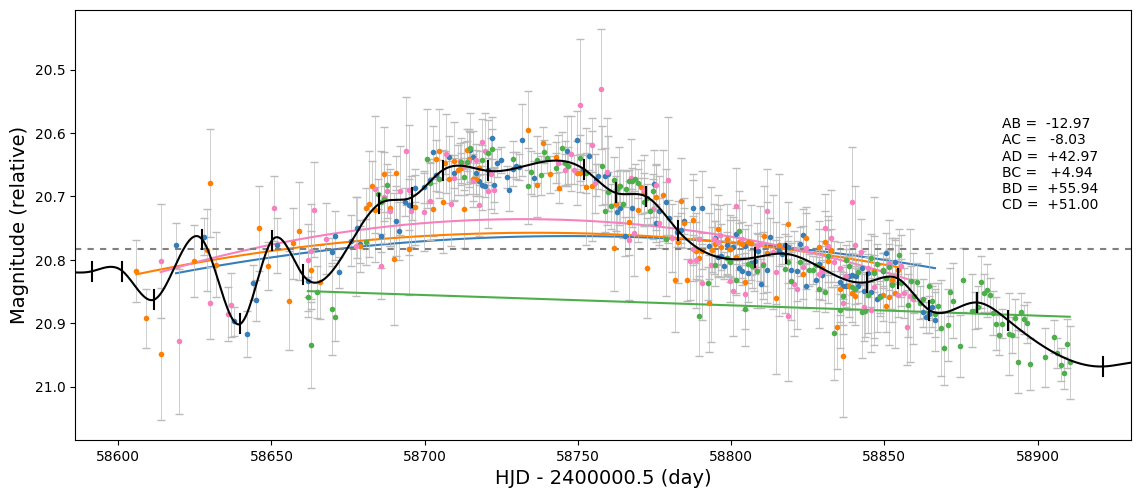

In [2]:
lensname = 'DESJ0029-3814'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.2, sigma_outlier=1.5, cutmask=True)

# initial guess
lcs[0].timeshift = 0
lcs[1].timehift = lcs[2].timeshift = -8
lcs[-1].timeshift = 45.0
ml1 = 'linear'
ml2 =  3*['quadratic'] + ['linear']
fit(lcs, ml2, 15)

# curves too short, gap creates confusion in mocks. But delay pretty clear: restrict tsrand.
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcs, mltouse=[ml1, ml2], knotstouse=[15, 20],
                      tsrand=8.0)  

## PSJ0030-1525 - WFI

lens='PSJ0030-1525' and mag_scatter<0.05 and seeing<2.9


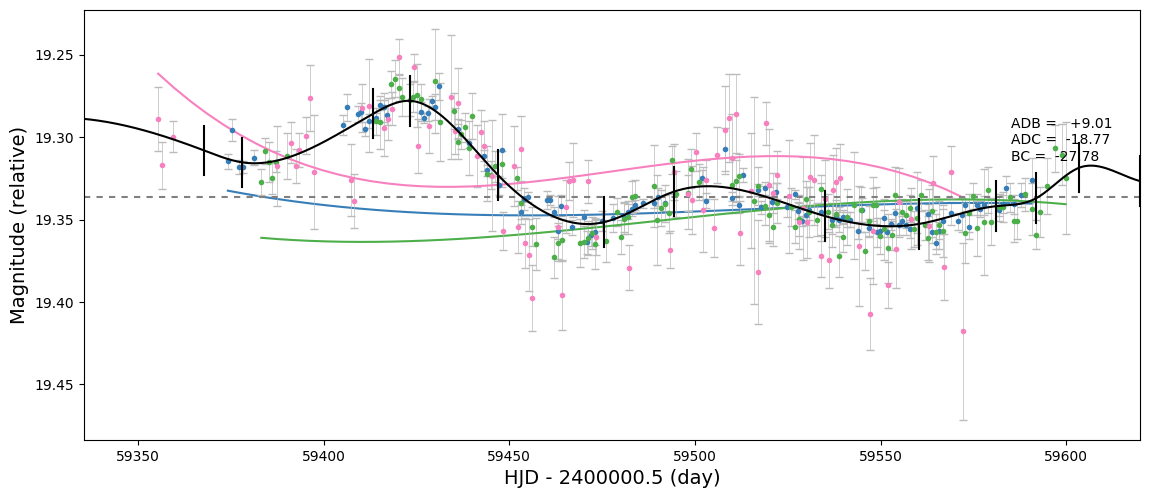

In [3]:
lcs, dataset_name = curve_loader.get_pycs3_curves('PSJ0030-1525', max_scatter=0.05)

lcsuse = select_curves_from_names(lcs, ['AD', 'B', 'C'])
#[l.resetshifts() for l in lcs]
fit(lcsuse, 'cubic', 25)
# knot step down to 22 fits features well, and up to 35. --then really smoothed out.
# ML models fit well from linear to spline_3_knot_fixed. Including everything.
db.save_for_pycs3_run('PSJ0030-1525', dataset_name=dataset_name, lcs=lcsuse, 
                      mltouse=["linear", "quadratic", "cubic", "spline_3_fixed_knot"], 
                      knotstouse=[20, 25, 30, 35])

## DESJ0053-2012 - WFI

lens='DESJ0053-2012' and mag_scatter<0.5 and seeing<2.9
WFI


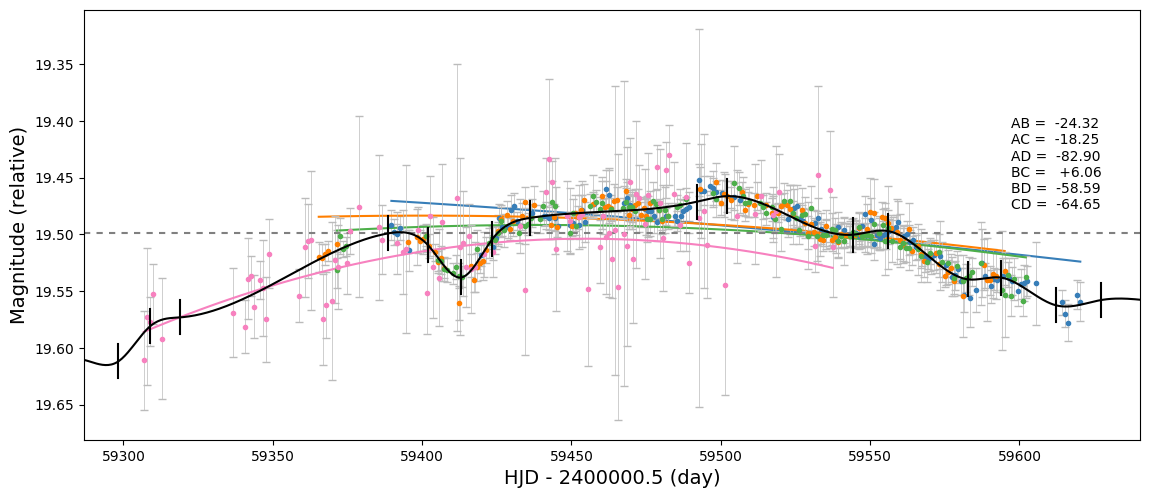

In [4]:
lensname = 'DESJ0053-2012'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.5, sigma_outlier=1.2, cutmask=True)
print(dataset_name)
lcs[3].mask[lcs[3].mags>22.02]=False
lcs[3].cutmask()
lcs[3].magshift = -2.3
lcs[3].timeshift = -95

fit(lcs, 'quadratic', 25)

db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcs, 
                      mltouse=["linear", "quadratic", "cubic", "spline_3_fixed_knot"], 
                      knotstouse=[20, 25, 30, 35])

## WG0214-2105

lens='WG0214-2105' and mag_scatter<0.08 and seeing<2.9


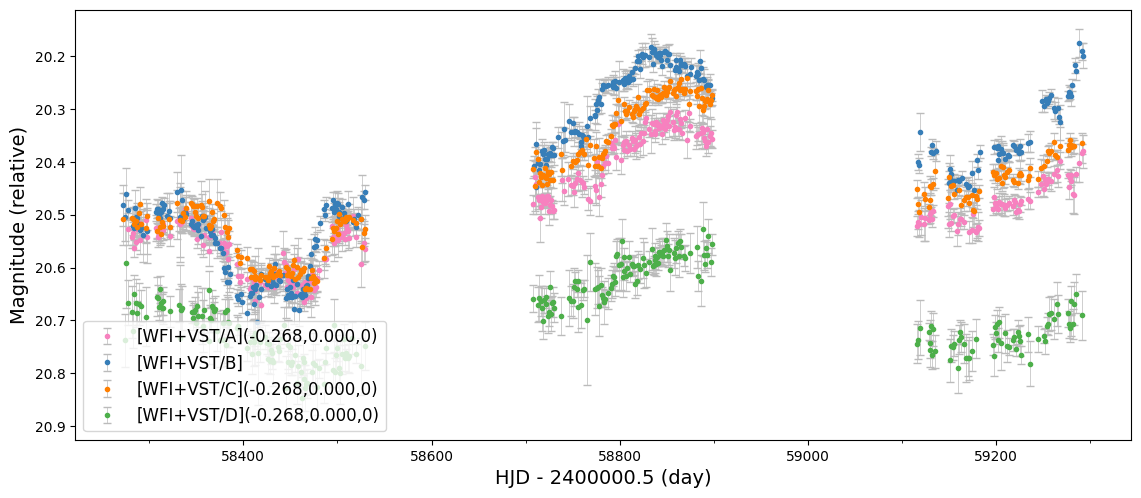

In [5]:
lensname = 'WG0214-2105'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.08, sigma_outlier=1.3, cutmask=True)

# bring last season closer:
modify_lcs_based_on_jds(lcs, jd_min=59000, delta_jd=-330, delta_mag=-0.05)
# bump up last curve
lcs[3].mags -= 0.6
see(lcs)

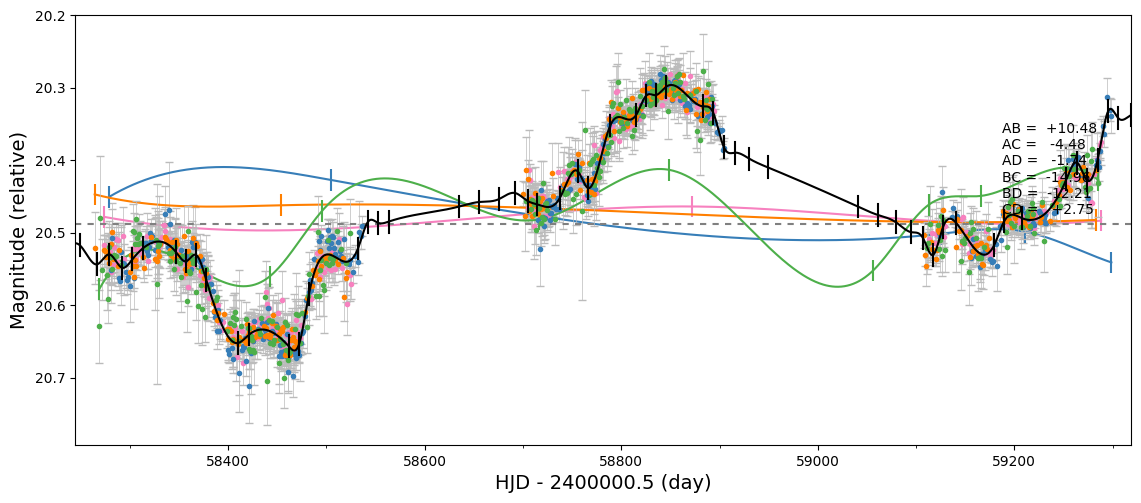

In [6]:
mltouse = [['spline_3', 'spline_5', 'spline_3', 'spline_9'], 
           ['spline_4', 'spline_6', 'spline_4', 'spline_10']]

fit(lcs, mltouse[0], 20, autoseasonsgap=100)

db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcs, 
                      mltouse=mltouse, 
                      knotstouse=[20, 25, 30, 35])

## HE0230-2130

lens='HE0230-2130' and mag_scatter<0.5 and seeing<2.9


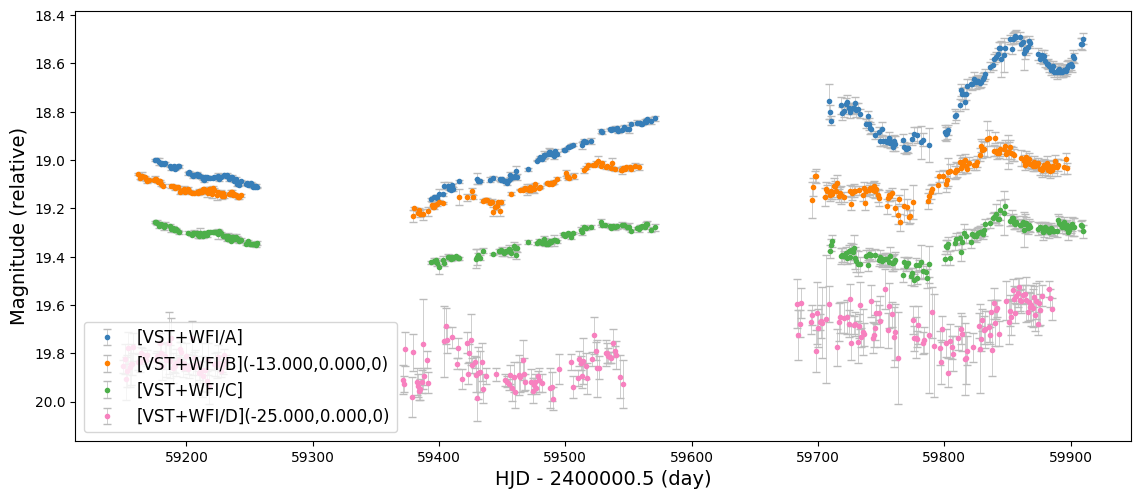

In [7]:
lensname = 'HE0230-2130'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.5, sigma_outlier=1.9, cutmask=1)

modify_lcs_based_on_jds(lcs, jd_min=59800, delta_mag=-0.7)
modify_lcs_based_on_jds(lcs, jd_min=59300, delta_jd=-50)
modify_lcs_based_on_jds(lcs, jd_min=59600, delta_jd=-350)

lcs[3].mask[lcs[3].mags>22.0] = False
lcs[3].cutmask()
lcs[2].mags -= 0.5
lcs[3].mags -= 2.0
lcs[1].timeshift = -13.
lcs[3].timeshift = -25
see(lcs)

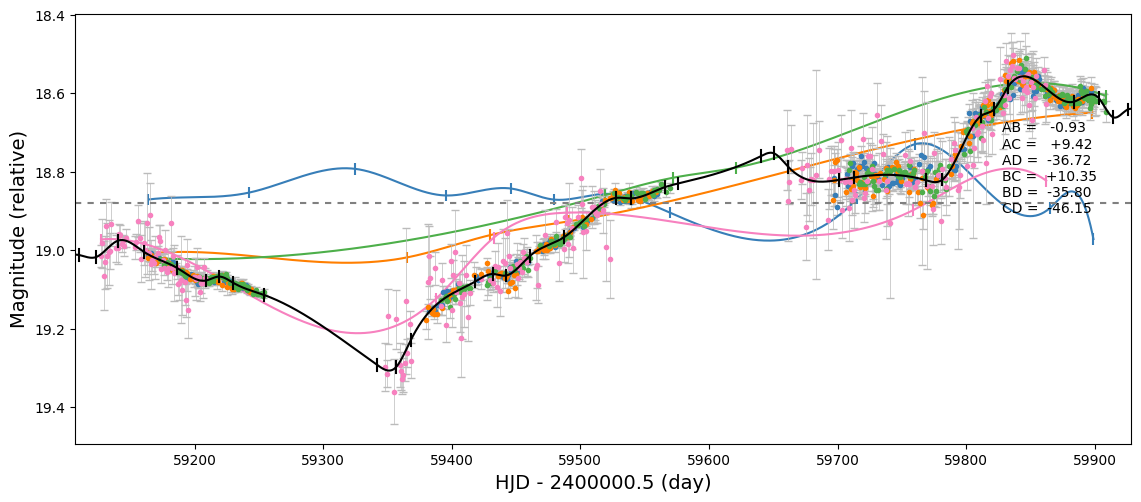

HE0230-2130


In [8]:
ml1 = ['spline_11'] + 2*['spline_4'] + ['spline_5']
ml2 = ['spline_12'] + 2*['spline_5'] + ['spline_6']
fit(lcs, ml2, 25)
# comments
print(lensname)
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcs, mltouse=[ml1, ml2], knotstouse=[19, 25, 30])

## ATLAS0259-1635 - VST + WFI

lens='ATLAS0259-1635' and mag_scatter<0.5 and seeing<2.9
VST+WFI


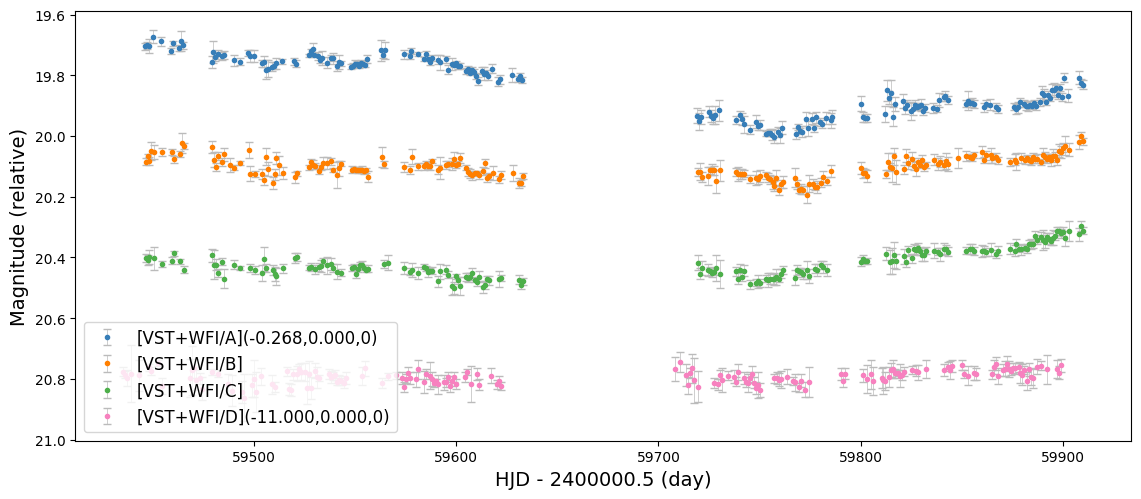

In [9]:
lensname = 'ATLAS0259-1635'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.5, sigma_outlier=3.5, cutmask=True)
print(dataset_name)
modify_lcs_based_on_jds(lcs, jd_min=60000, delta_mag=0.08)
modify_lcs_based_on_jds(lcs, jd_min=60000, delta_jd=-400)
lcs[3].timeshift = -11
see(lcs)

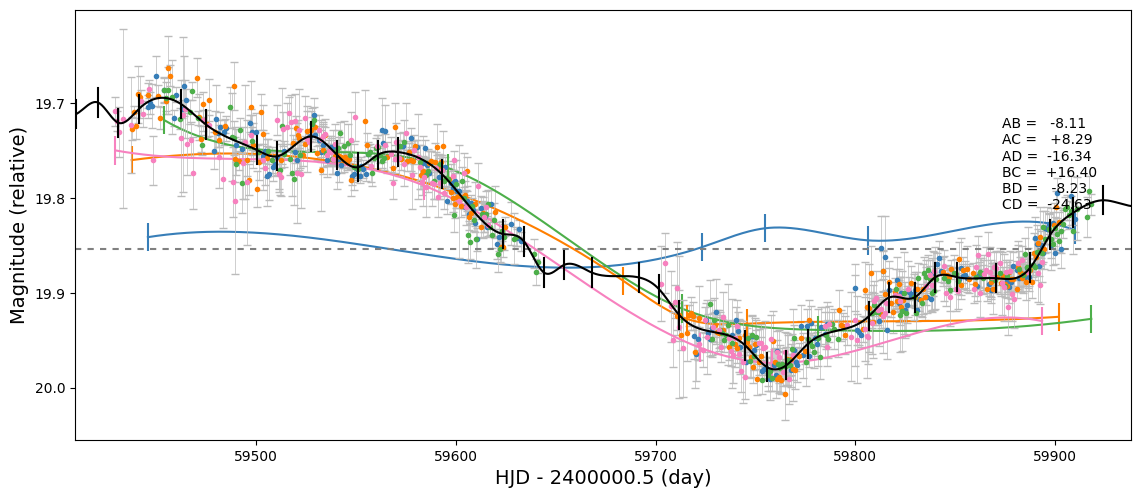

In [10]:
ml1 = 'spline_4'
ml2 = 'spline_5'
fit(lcs, ml2, 15)

db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcs, mltouse=[ml1, ml2], knotstouse=[15, 20],
                      tsrand=8)  # forced as D is sligthly multi modal: but the second possibility takes a lot more ML, unlikely.

## DES0420-4037 - VST

lens='DESJ0420-4037' and mag_scatter<0.5 and seeing<2.9


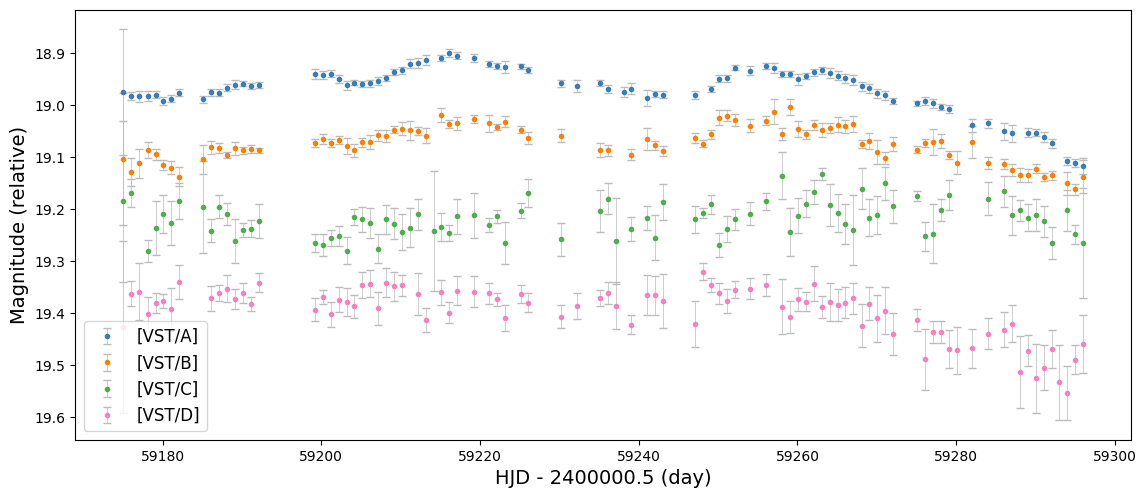

In [11]:
lensname = 'DESJ0420-4037'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.5, sigma_outlier=4., cutmask=False)
for lc in lcs:
    lc.resetshifts()
lcs[0].mask[(lcs[0].jds>59183) * ( lcs[0].jds <59184)] = False
lcs[0].mask[(lcs[0].jds>59214) * ( lcs[0].jds <59215)] = False
lcs[1].mask[(lcs[1].jds>59214) * ( lcs[1].jds <59215)] = False
lcs[1].mask[(lcs[1].jds>59237) * ( lcs[1].jds <59238.8)] = False
lcs[1].mags -= 0.9
lcs[2].mags -= 2
lcs[3].mags -= 2
for lc in lcs:
    lc.cutmask()
see(lcs)

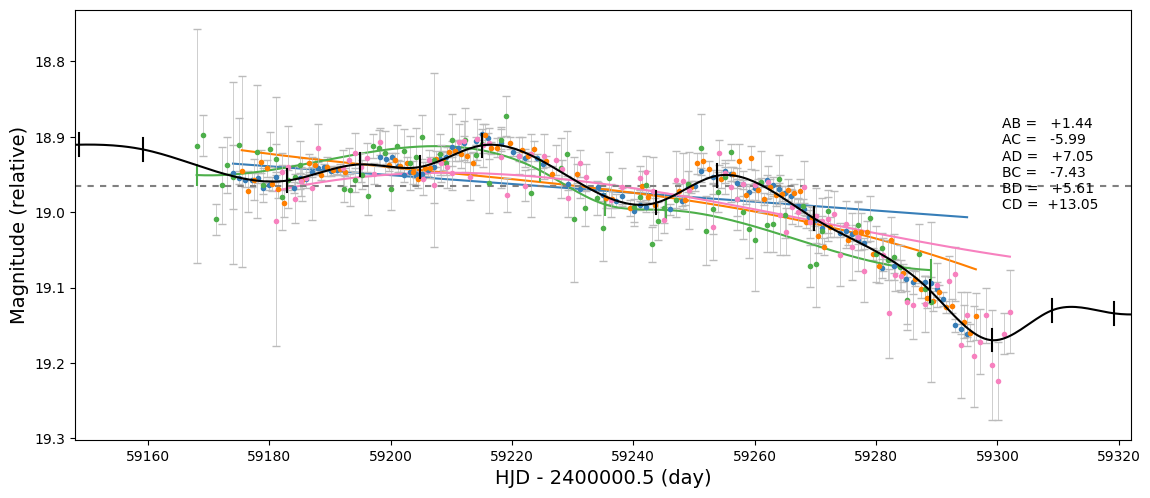

In [12]:
fit(lcs, ['linear', 'cubic', 'spline_5', 'cubic'], 15)
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcs, mltouse=['cubic', 'spline_3_fixed_knot', 'spline_3'], knotstouse=[15, 25, 35])

## DESJ0602-4335 - WFI

lens='DESJ0602-4335' and mag_scatter<0.03 and seeing<2.9


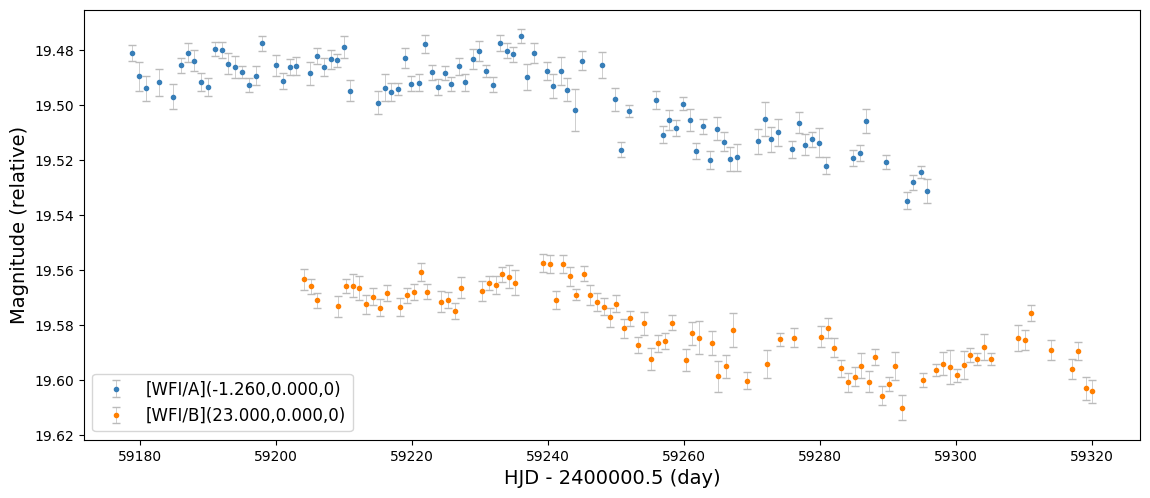

In [13]:
lensname = 'DESJ0602-4335'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.03, sigma_outlier=2.05, cutmask=True)

# mag errs surestimated here
for lc in lcs:
    lc.magerrs *= 0.4
lcs[1].mask[lcs[1].mags<19.65685]=False
lcs[1].cutmask()
lcs[1].mags -= 0.1
lcs[1].timeshift = 23

see(lcs)

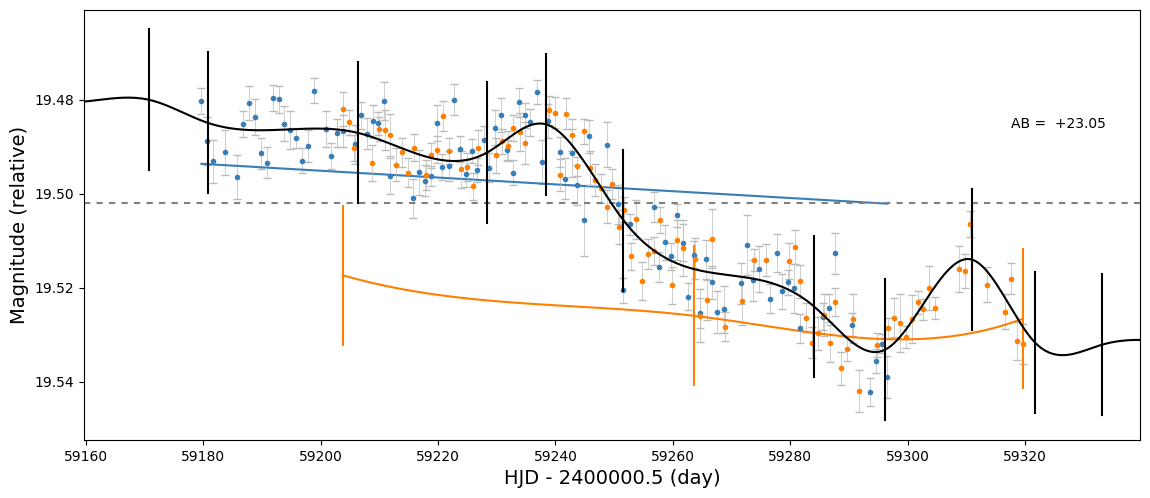

In [14]:
mltouse = ['linear', ['linear', 'spline_3_fixed_knot'], ['cubic', 'cubic']]
lcs[0].timeshift = 0
lcs[1].timeshift = 23
fit(lcs, mltouse[1], 20)

db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcs, mltouse=mltouse, knotstouse=[15, 20, 25])

## J0607-2152 - VST

lens='J0607-2152' and mag_scatter<0.25 and seeing<2.9


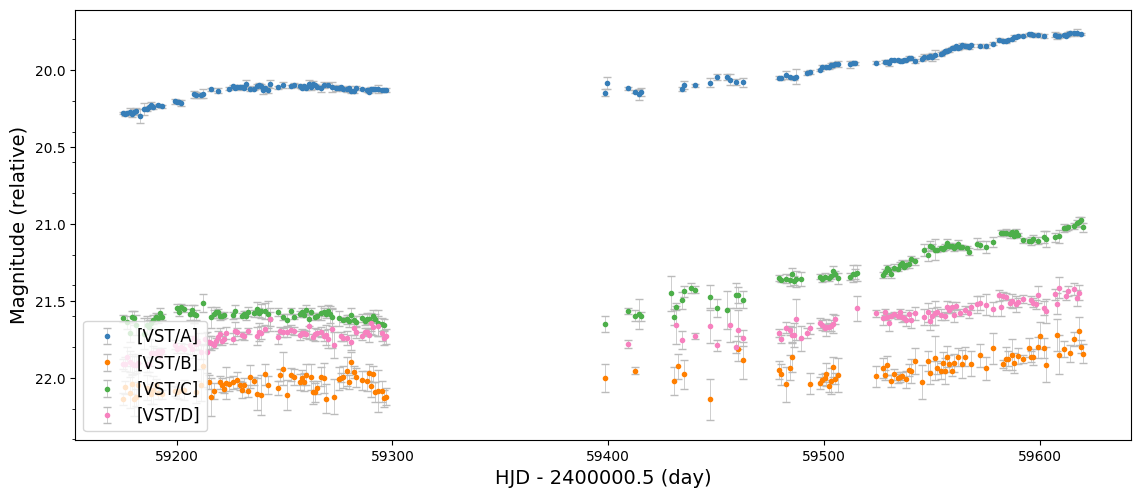

In [15]:
lensname = 'J0607-2152'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.25, sigma_outlier=1.2, cutmask=True)
modify_lcs_based_on_jds(lcs, 59350, delta_jd=-50)
for lc in lcs:
    lc.resetshifts()
lcs[1].mask[lcs[1].mags>22.15] = False
lcs[1].cutmask()
see(lcs)

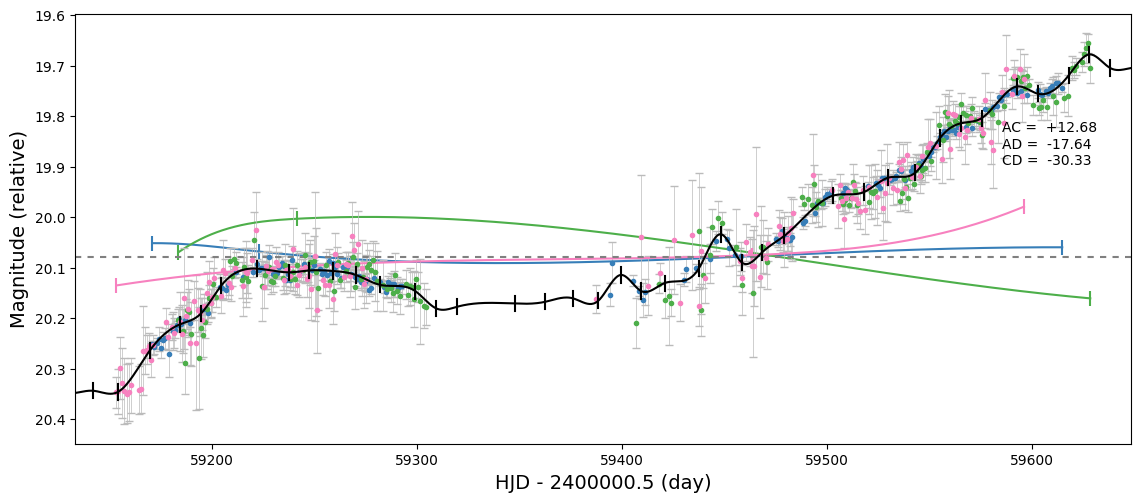

In [16]:
lcsuse = lcs[:1]+lcs[2:]
fit(lcsuse, 'spline_3', 13, autoseasonsgap=1000)
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=['spline_3_fixed_knot', 'spline_3'], knotstouse=[15, 17])

## J0659+1629 - VST

lens='J0659+1629' and mag_scatter<5 and seeing<2.9
LCOnotMuscat+VST+LCOMuscat3


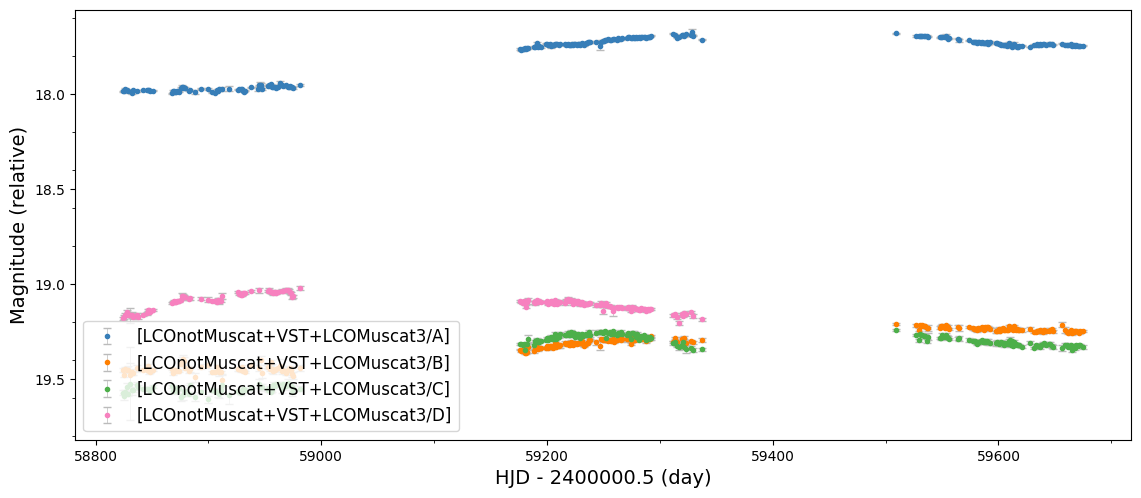

In [17]:
lensname = 'J0659+1629'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=5, sigma_outlier=4, cutmask=1)
for lc in lcs:
    lc.resetshifts()
#lcs[3].mask[lcs[3].jds>59400] = False
# get rid of second part of D which does not overlap
lcs[3].cutmask()

modify_lcs_based_on_jds(lcs, jd_min=59400, delta_mag=-0.05)

lcs[3].mask[lcs[3].jds>59400] = False
lcs[3].cutmask()
modify_lcs_based_on_jds(lcs, jd_max=59000, delta_mag=0.8)

    
print(dataset_name)
see(lcs)

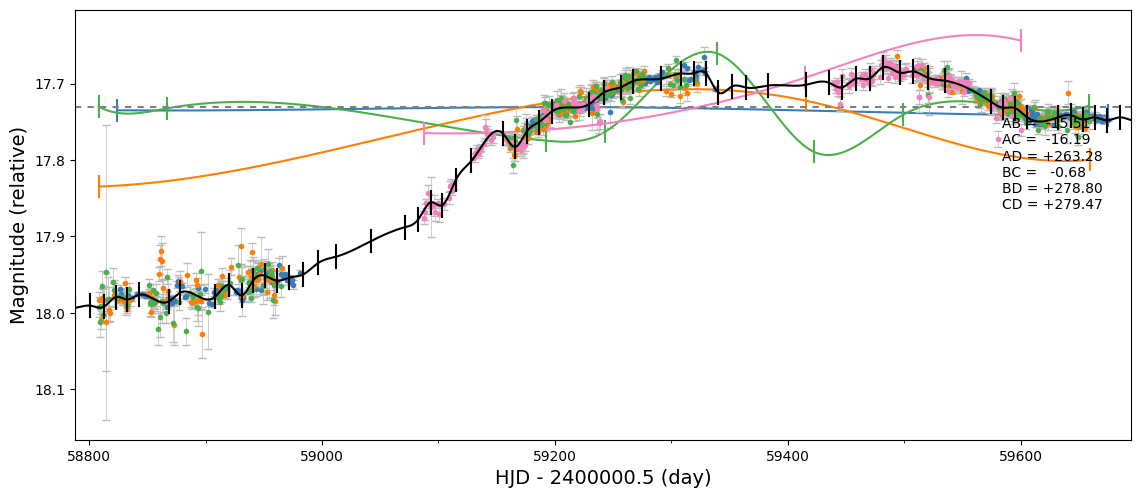

J0659+1629


In [18]:
for lc in lcs:
    lc.resetshifts()
lcs[0].timeshift = 0
lcs[1].timeshift = -16.
lcs[2].timeshift = -16
lcs[3].timeshift = 270. 
lcsuse = lcs
ml1 = 2*['spline_3_fixed_knot']+['spline_8', 'spline_3_fixed_knot']
ml2 = 2*['spline_3']+['spline_8', 'spline_3']
ml3 = 2*['spline_5']+['spline_9', 'spline_5']
fit(lcsuse, ml2, 15, autoseasonsgap=1000)
#fit(lcs, 'spline_3', 25)
# comments
print(lensname)
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=[ml1, ml2, ml3], knotstouse=[15, 20, 25],
                      tsrand=15)


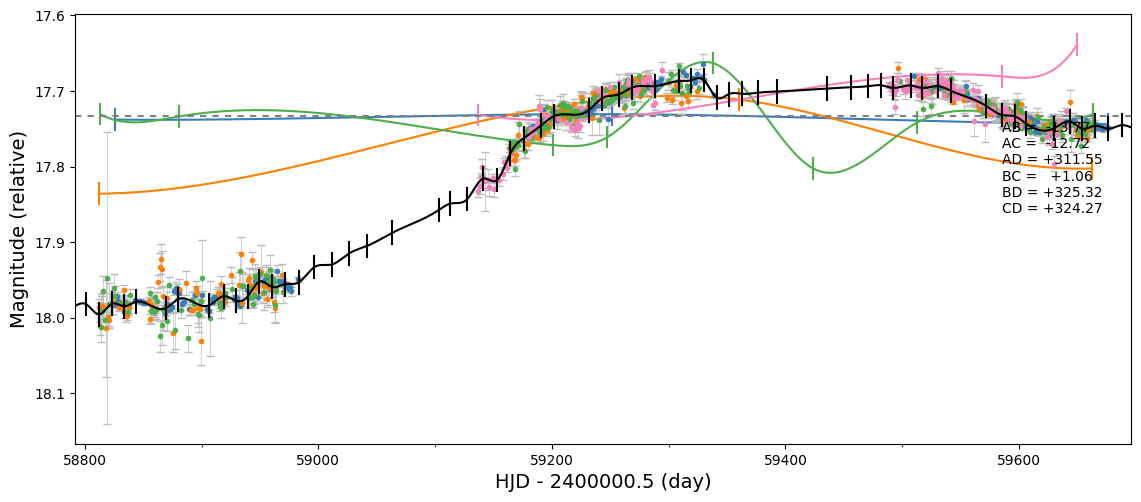

J0659+1629


In [19]:
for lc in lcs:
    lc.resetshifts()
lcs[0].timeshift = 0
lcs[1].timeshift = -16.
lcs[2].timeshift = -16
lcs[3].timeshift = 340. 
lcsuse = lcs
ml1 = 2*['spline_3_fixed_knot']+['spline_8', 'spline_3_fixed_knot']
ml2 = 2*['spline_3']+['spline_8', 'spline_3']
ml3 = 2*['spline_5']+['spline_9', 'spline_5']
fit(lcsuse, ml2, 15, autoseasonsgap=1000)
#fit(lcs, 'spline_3', 25)
# comments
print(lensname)
db.save_for_pycs3_run(lensname, dataset_name=dataset_name+'-2ndpossibility', lcs=lcsuse, mltouse=[ml1, ml2, ml3], knotstouse=[15, 20, 25],
                      tsrand=15)


## J0832+0404

lens='J0832+0404' and mag_scatter<0.05 and seeing<2.9


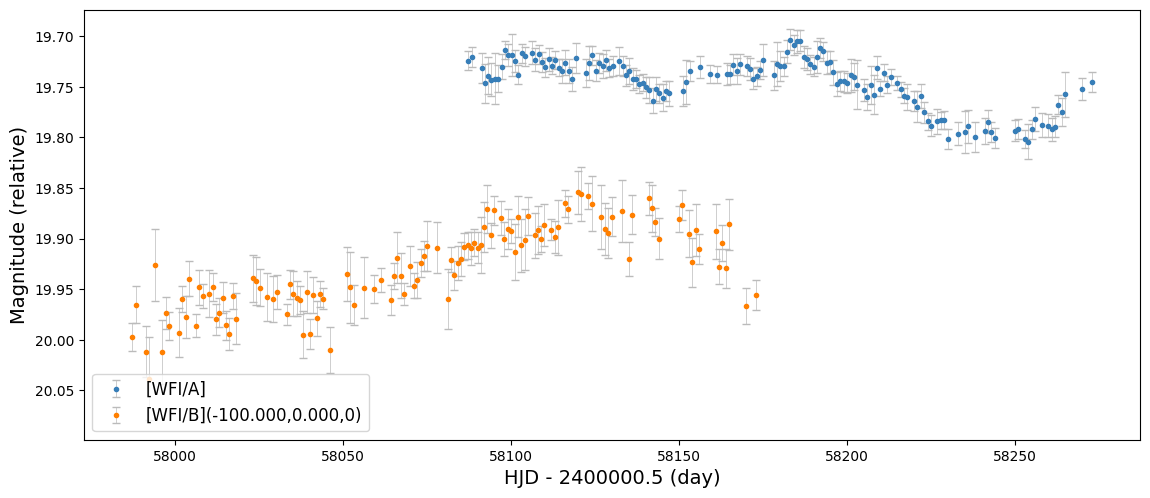

In [20]:
lensname = 'J0832+0404'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.05, sigma_outlier=1.9, cutmask=1)
for lc in lcs:
    lc.resetshifts()
lcs = sorted(lcs, key=lambda lc: lc.object)
lcs[1].mags -= 1.1
lcs[1].timeshift = -100

see(lcs)

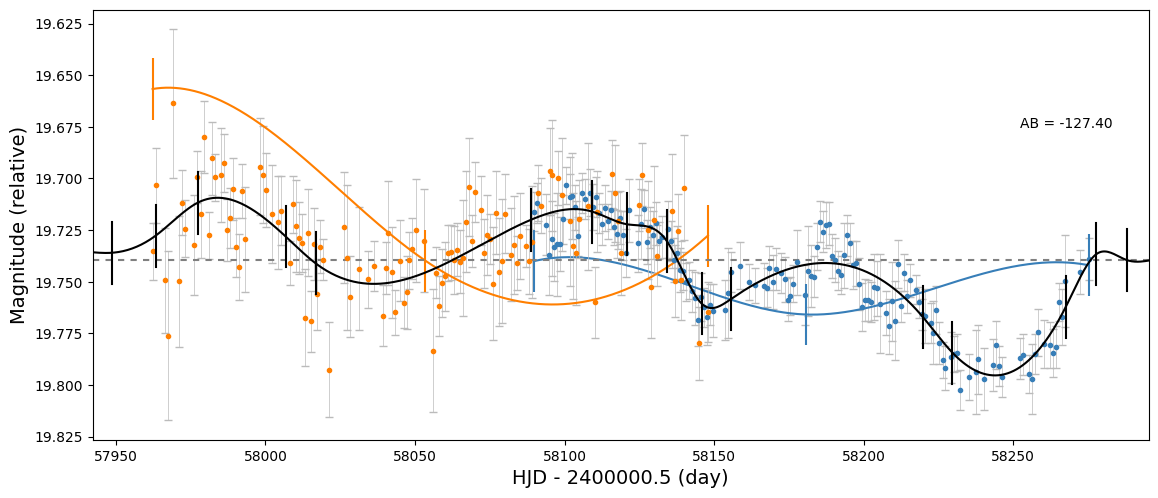

In [21]:
lcsuse = lcs

fit(lcsuse, 'spline_3_fixed_knot', 25)
#fit(lcs, 'spline_3', 25)
# comments
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=['linear', 'spline_3_fixed_knot', 'spline_3'], 
                      knotstouse=[15, 25, 35], tsrand=10)

## RXJ0911+0551 - WFI

lens='RXJ0911+0551' and mag_scatter<0.2 and seeing<2.9
WFI


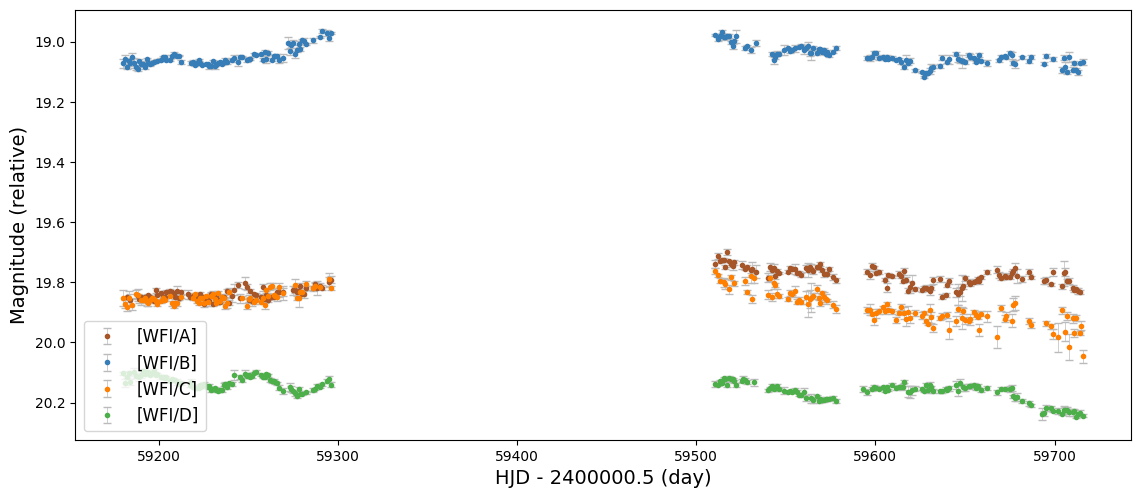

In [22]:
lensname = 'RXJ0911+0551'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.2, sigma_outlier=1.80, cutmask=1)
for lc in lcs:
    lc.resetshifts()
    lc.mags[lc.jds>59400] += 0.00
    #lc.jds[lc.jds>59400] -= 380
    lc.magerrs *= 0.5
print(dataset_name)
lcs = select_curves_from_names(lcs, ['A', 'B', 'C', 'D'])
modify_lcs_based_on_jds(lcs, jd_min=59400, delta_jd=-390)
see(lcs)

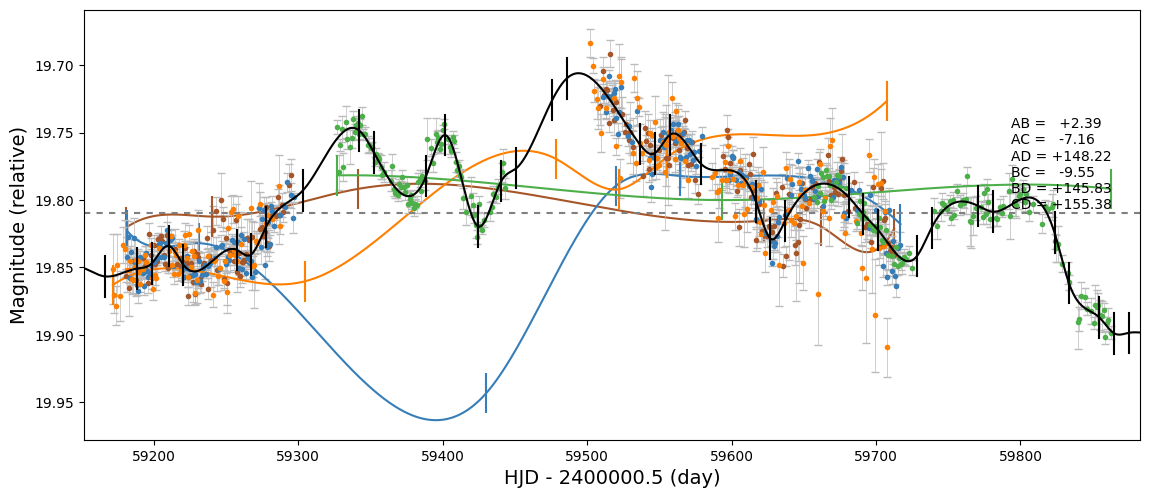

In [23]:
lcsuse = deepcopy(lcs)
#lcsuse = lcs[1:2] + lcs[4:]
lcsuse[0].timeshift = 0
lcsuse[1].timeshift = 3
lcsuse[2].timeshift = -5
lcsuse[3].timeshift = 146

ml1 = 3*['spline_6'] + ['spline_3_fixed_knot']
ml2 = 3*['spline_7'] + ['spline_3_fixed_knot']
fit(lcsuse, ml1, 20)

# gotta keep tsrand small: because limited intersect with D, and short delays within ABC.
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=['spline_3_fixed_knot', 'spline_3'], 
                      knotstouse=[15, 20], tsrand=10)

## J0924+0219 - VST + WFI

lens='J0924+0219' and mag_scatter<0.7 and seeing<2.9 and (telescope='VST' or telescope='WFI')
VST+WFI


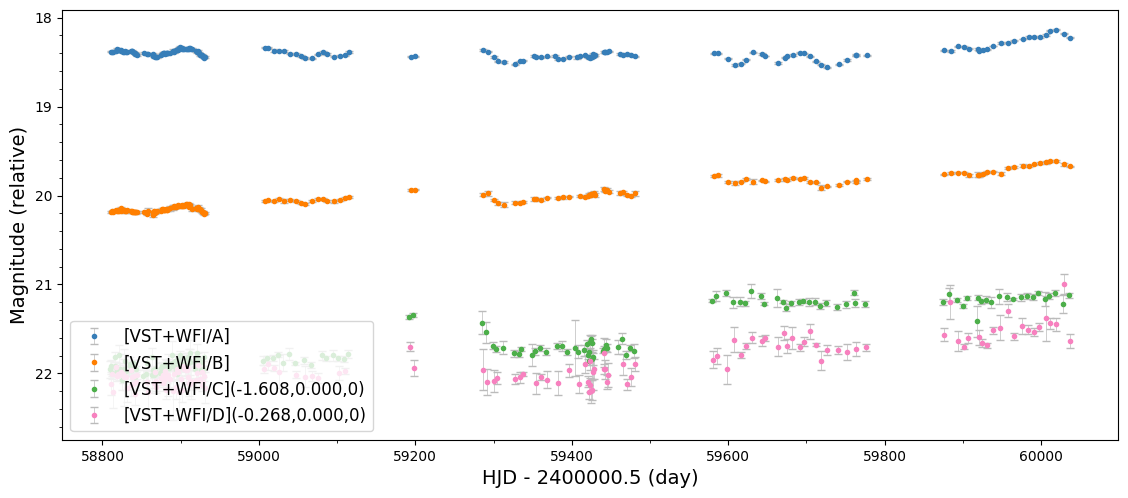

In [24]:
lensname = 'J0924+0219'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.7, sigma_outlier=4.5, cutmask=1, telescope=['VST', 'WFI'])

print(dataset_name)
lcs = sorted(lcs, key=lambda lc: lc.object)
for lc in lcs:
    lc.mags[(lc.jds<59000)] -= 0.1
    lc.mags[(lc.jds>59400)] -= 0.3
    lc.mags[(lc.jds>59900)] -= 0.2
    lc.jds[lc.jds>60200] -= 70
    lc.jds[lc.jds>59800] -= 70
    lc.jds[lc.jds>59410] -= 70
    lc.jds[lc.jds>59000] -= 180

for lc in lcs:
    lc.cutmask()
see(lcs);

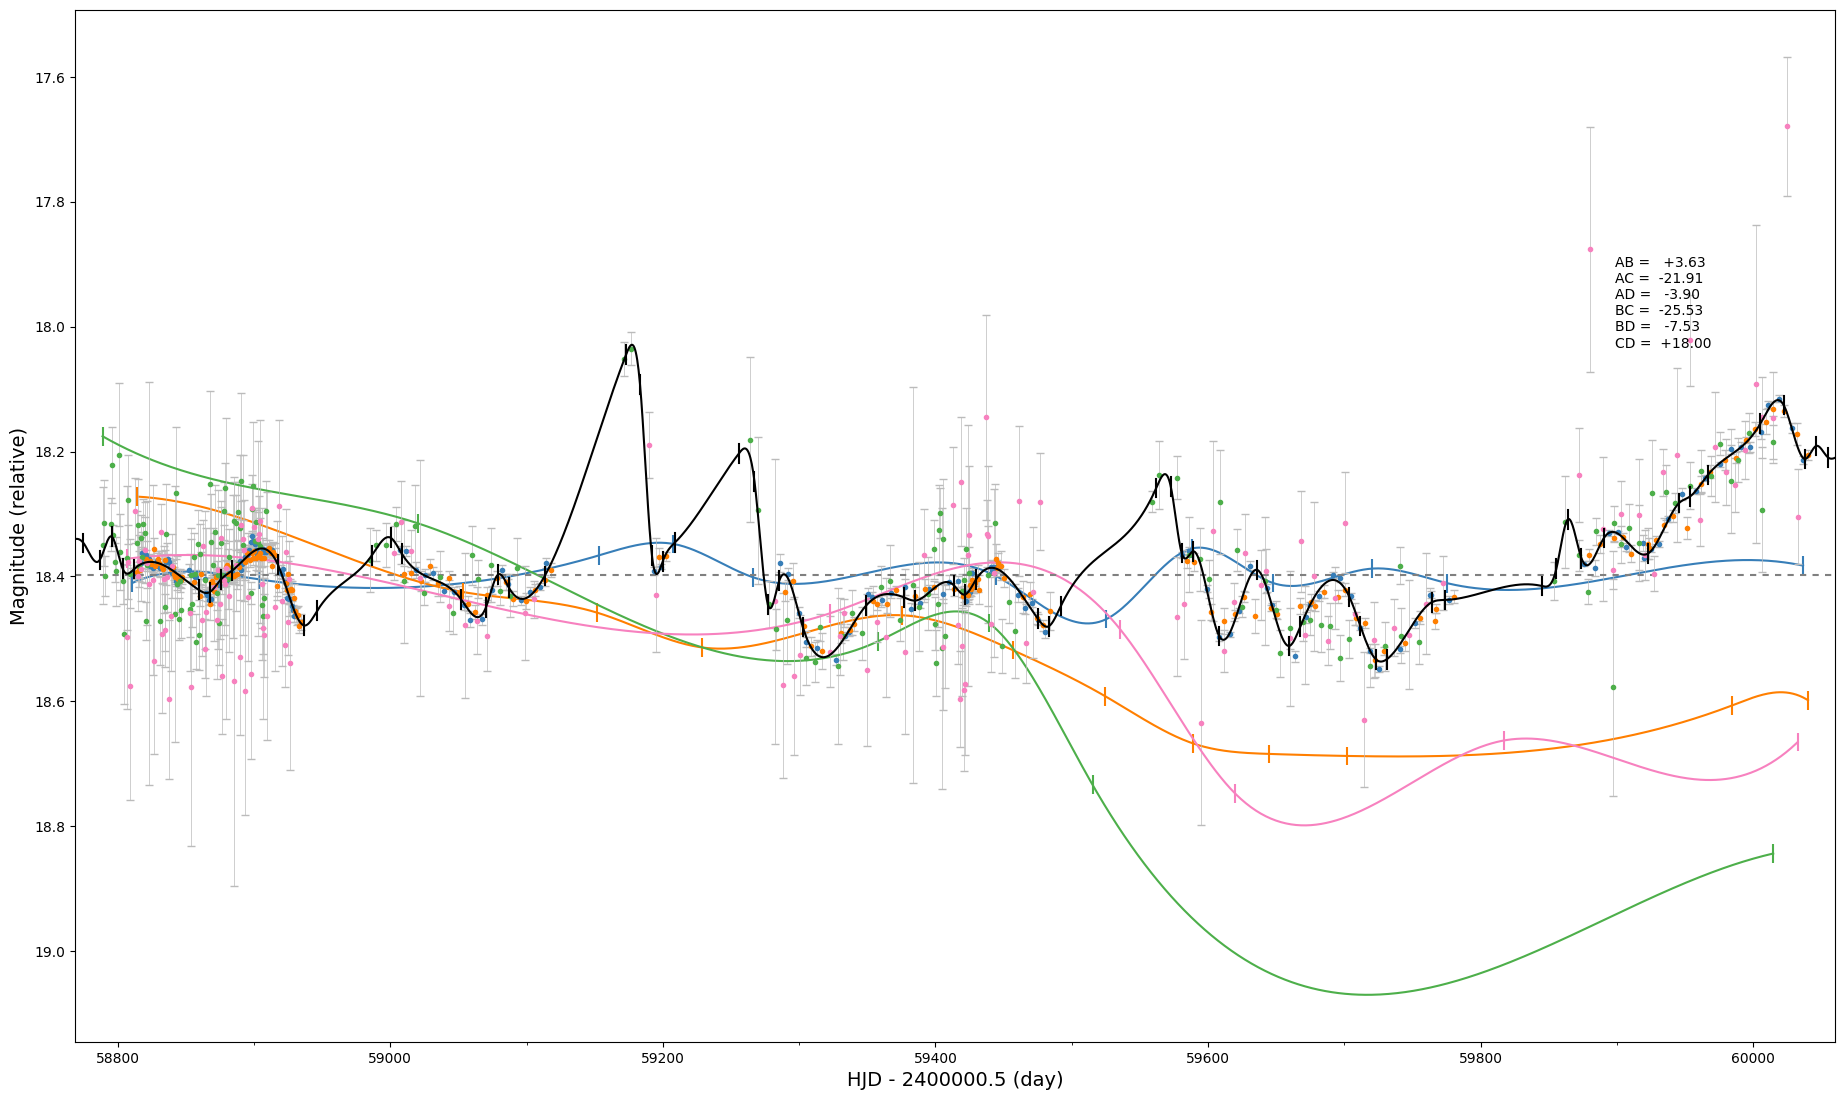

J0924+0219


In [25]:
for lc in lcs:
    lc.resetshifts()
Ncc = 4

lcsuse = lcs[:Ncc]
lcsuse[1].timeshift = 3.1
if Ncc > 2:
    lcsuse[2].timeshift = -15

ml1 = ['spline_12', 'spline_12', 'spline_6', 'spline_6']
ml2 = ['spline_13', 'spline_13', 'spline_7', 'spline_7']
ml3 = ['spline_14', 'spline_14', 'spline_8', 'spline_8']
fit(lcsuse, ml1[:Ncc], 20, bokeps=8, figsize=(20,12))
#fit(lcs, 'spline_3', 25)
# comments
print(lensname)

db.save_for_pycs3_run(lensname, dataset_name='VST+WFI', lcs=lcsuse, mltouse=[ml1[:Ncc], ml2[:Ncc], ml3[:Ncc]], knotstouse=[15, 20, 25])

## GRALJ1131-4419 - VST + WFI

lens='GRALJ1131-4419' and mag_scatter<5 and seeing<2.9
WFI+VST


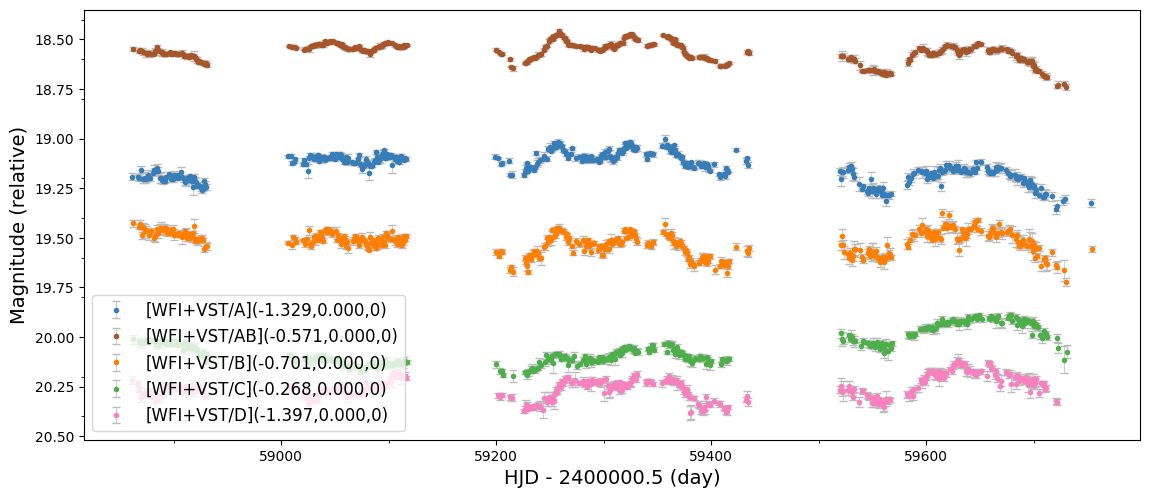

In [26]:
lensname = 'GRALJ1131-4419'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=5, sigma_outlier=100.5, cutmask=1)

print(dataset_name)
lcs = sorted(lcs, key=lambda lc: lc.object)

# okkk align to make microlensing easier to correct
for lc in lcs:
    lc.mags[(lc.jds>59000)*(lc.jds<59400)] += 0.2
    lc.jds[(lc.jds>59000)] -= 180
    lc.mags[lc.jds>59300] += 0.15
    lc.jds[lc.jds>59300] -= 170
    lc.mags[lc.jds>59500] -= 0.1
    lc.jds[lc.jds>59500] -= 50

see(lcs)

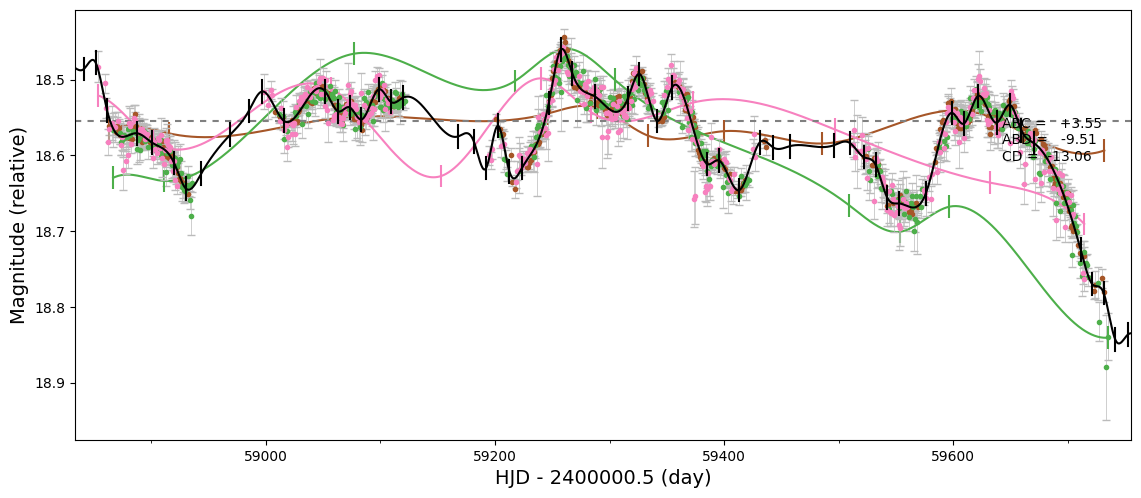

In [27]:
for lc in lcs:
    lc.resetshifts()

lcsuse = select_curves_from_names(lcs, ['AB', 'C', 'D'])
ml1 = 'spline_10'
ml2 = 'spline_11'
fit(lcsuse, ml1, 16)

db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=[ml1, ml2], knotstouse=[13, 16, 19])

## 2M1310-1714 - VST

lens='2M1310-1714' and mag_scatter<0.1 and seeing<2.9


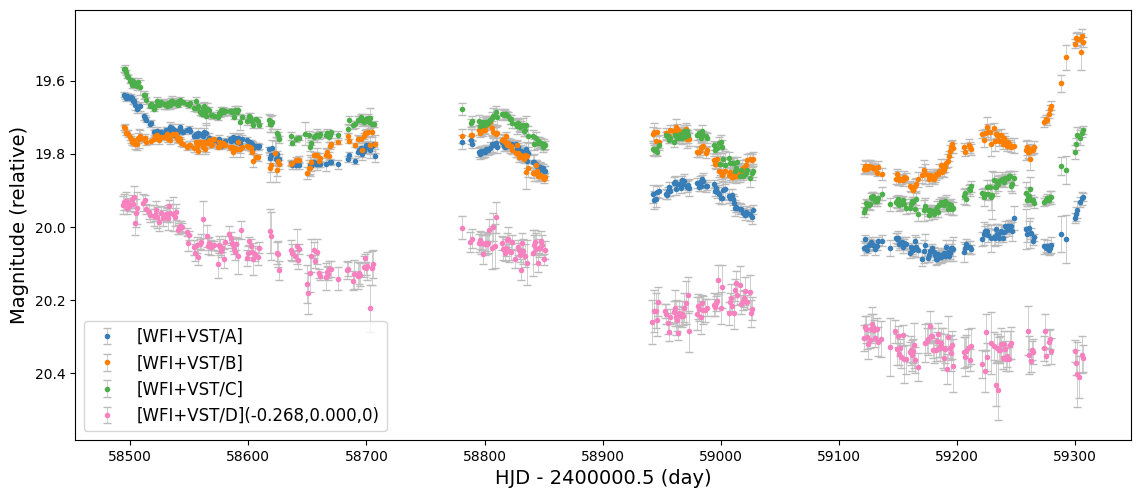

In [28]:
lensname = '2M1310-1714'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.1, sigma_outlier=2., cutmask=1)

lcs = sorted(lcs, key=lambda lc: lc.object)

# align to make microlensing easier to correct
for lc in lcs:
    lc.mags[lc.jds>58750] -= 0.2
    lc.jds[(lc.jds>58800)] -= 80
    lc.mags[lc.jds>59000] += 0.05
    lc.jds[(lc.jds>59000)] -= 190
    lc.mags[lc.jds>59200] -= 0.05
    lc.jds[(lc.jds>59200)] -= 215
lcs[-1].mags -= 1.1
see(lcs)

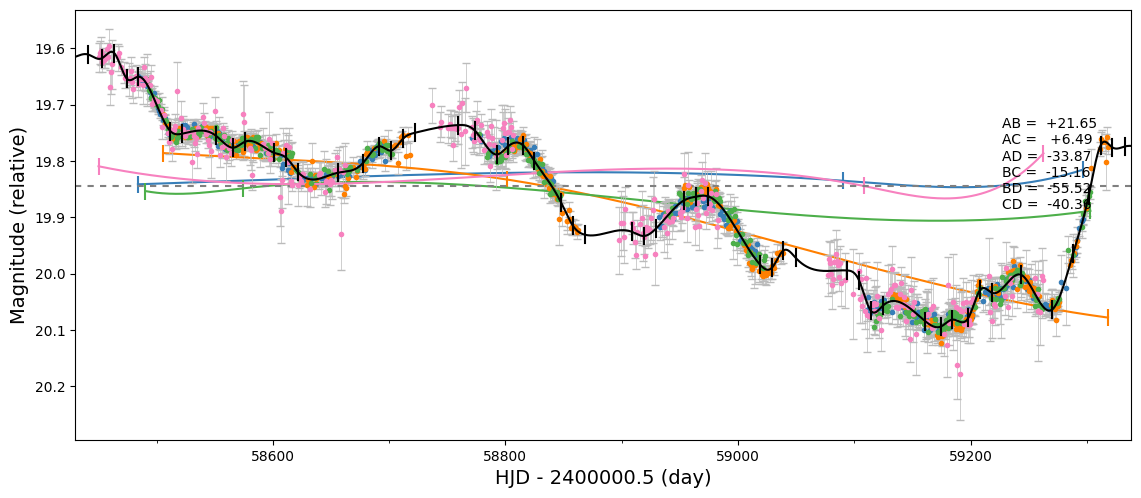

In [29]:
for lc in lcs:
    lc.resetshifts()

lcsuse = lcs[:4]

fit(lcsuse, 'spline_3', 17)

db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=['spline_3', 'spline_4'], knotstouse=[17, 20, 25])

## J1537-3010 - VST + WFI

lens='J1537-3010' and mag_scatter<0.1 and seeing<2.9


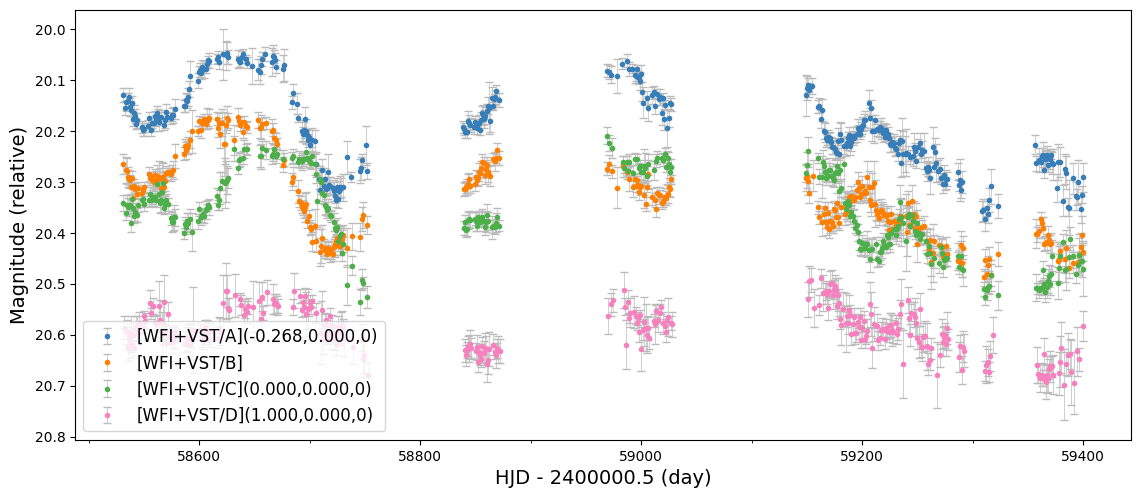

In [30]:
lensname = 'J1537-3010'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.1, sigma_outlier=1.6, cutmask=1)

lcs = sorted(lcs, key=lambda lc: lc.object)

# okkk align to make microlensing easier to correct
for lc in lcs:
    lc.jds[(lc.jds>58800)] -= 60
    lc.mags[lc.jds>59000] -= 0.15
    lc.jds[lc.jds>59000] -= 210
    lc.mags[lc.jds>59300] += 0.1
    lc.jds[lc.jds>59300] -= 180
lcs[-1].mags -= 0.45
see(lcs)

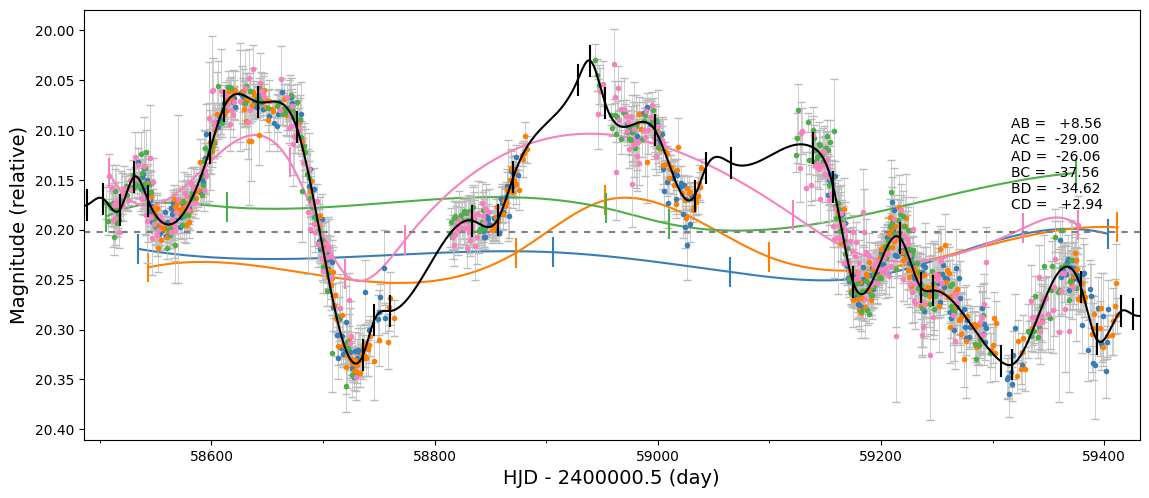

In [31]:
for lc in lcs:
    lc.resetshifts()

lcsuse = lcs[:4]
ml1 = 3*['spline_4'] + ['spline_7']
ml2 = 3*['spline_5'] + ['spline_8']
fit(lcsuse, ml2, 30)
#fit(lcs, 'spline_3', 25)
# comments
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=[ml1, ml2], knotstouse=[20, 25, 30])

## PSJ1606-2333 - VST

lens='PSJ1606-2333' and mag_scatter<0.1 and seeing<2.9


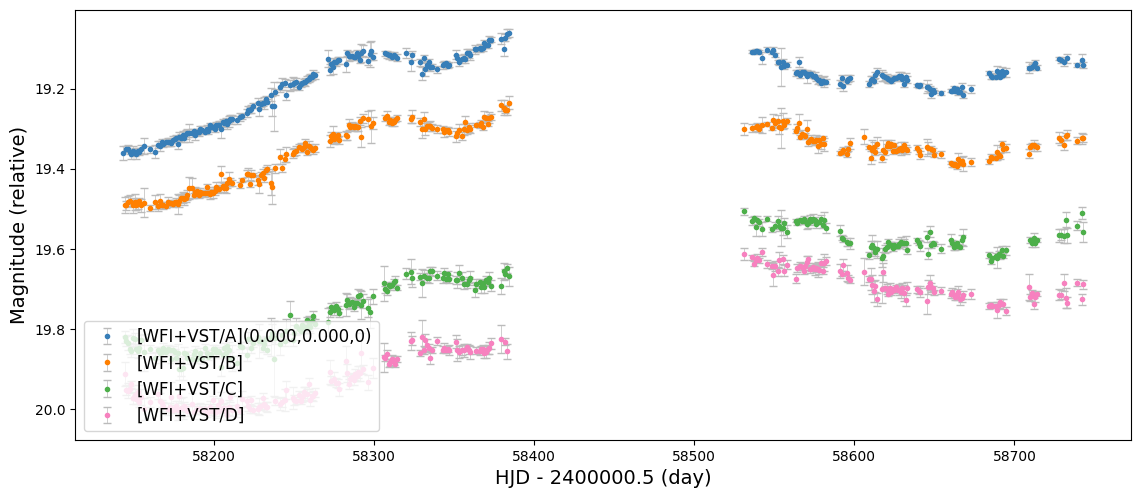

In [32]:
lensname = 'PSJ1606-2333'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.1, sigma_outlier=2.5, cutmask=0)

lcs = sorted(lcs, key=lambda lc: lc.object)[:4]
for lc in lcs:
    lc.mags[lc.jds>59000] += 0.09
    lc.jds[lc.jds>59000] -= 1100
    lc.mask[(lc.jds>58528)*(lc.jds<58529)] = False
    lc.cutmask()

see(lcs)

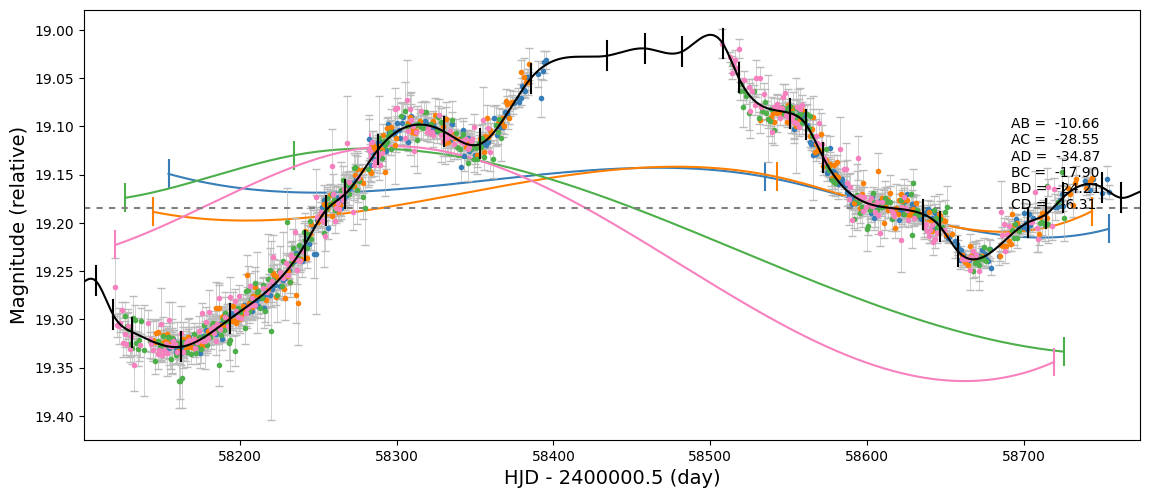

In [33]:
for lc in lcs:
    lc.resetshifts()

lcsuse = lcs

fit(lcsuse, 'spline_3', 25)

db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=['spline_3', 'spline_4'], knotstouse=[15, 25, 30])

## WGD2021-4115

lens='WGD2021-4115' and mag_scatter<0.2 and seeing<2.9
WFI


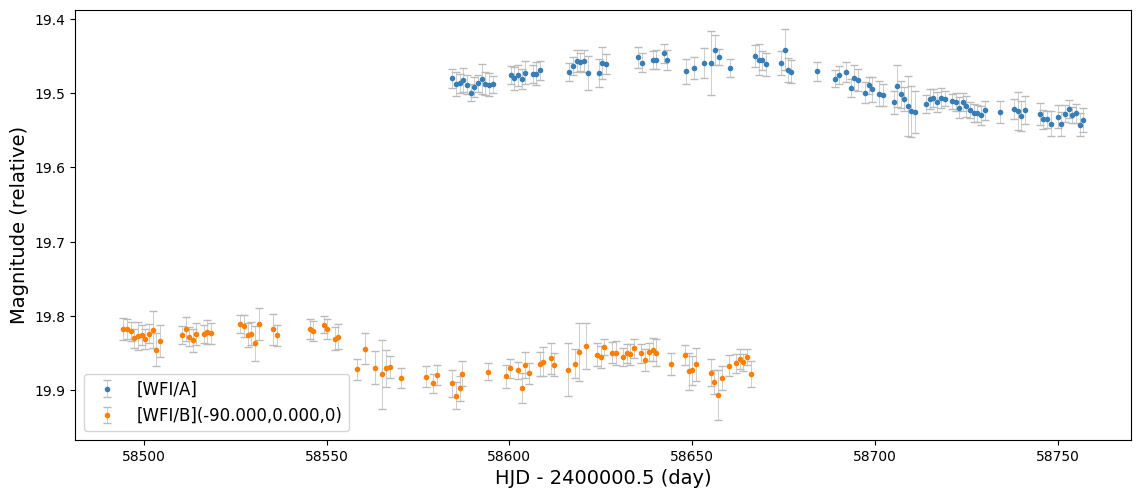

In [34]:
lensname = 'WGD2021-4115'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.2, sigma_outlier=1.9, cutmask=1)

print(dataset_name)
lcs = sorted(lcs, key=lambda lc: lc.object)

lcs[1].mask[lcs[1].mags>19.91]=False
lcs[1].cutmask()
lcs[1].timeshift = -90

see(lcs)

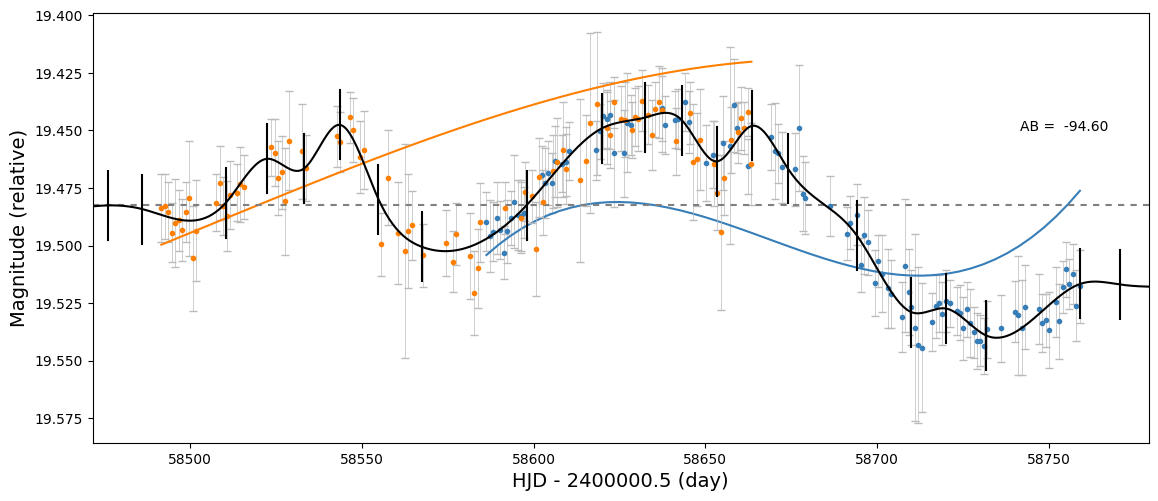

In [35]:
lcsuse = deepcopy(lcs)
ml1 = 'linear'
ml2 = 'quadratic'
ml3 = 'cubic'
fit(lcsuse, ml3, 15)

# we're very close to the edge, but the feature at 58660 seems sound. set low tsrand so the estimation doesn't start
# with no overlap of the curves.
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=[ml1, ml3], knotstouse=[15, 20],
                      tsrand=8)

## WFIJ2026-4536 - VST

lens='WFIJ2026-4536' and mag_scatter<0.05 and seeing<2.9
VST
['A', 'AD', 'B', 'C', 'D']


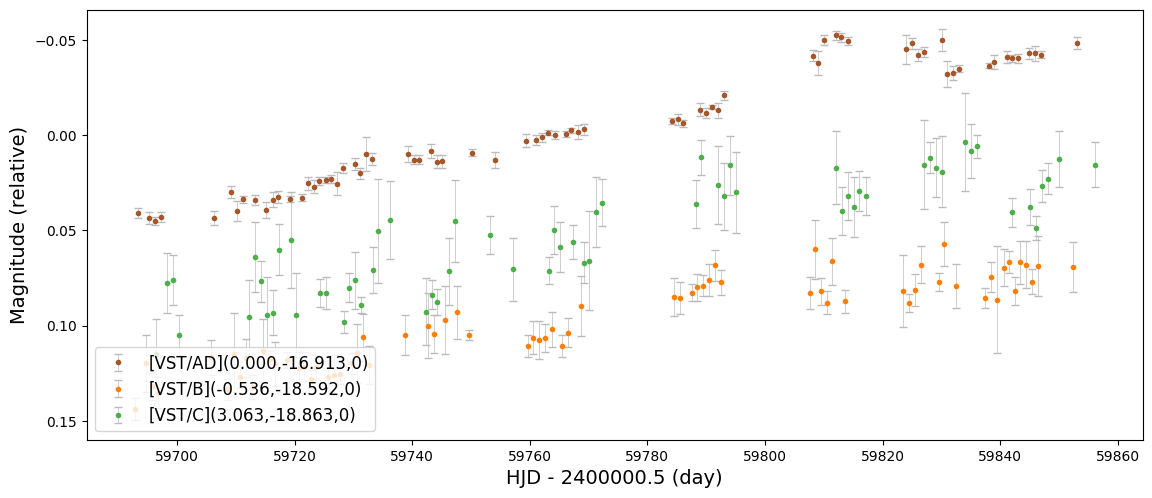

['AD', 'B', 'C']


In [36]:
lensname = 'WFIJ2026-4536'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.05, sigma_outlier=2.5, cutmask=1)

print(dataset_name)
lcs = sorted(lcs, key=lambda lc: lc.object)
print([lc.object for lc in lcs])
lcs = [lcs[1], lcs[2], lcs[3]]
for lc, off in zip(lcs, [0., 0.1, 0.05]):
    lc.magshift = -np.median(lc.mags) + off
see(lcs)
print([lc.object for lc in lcs])


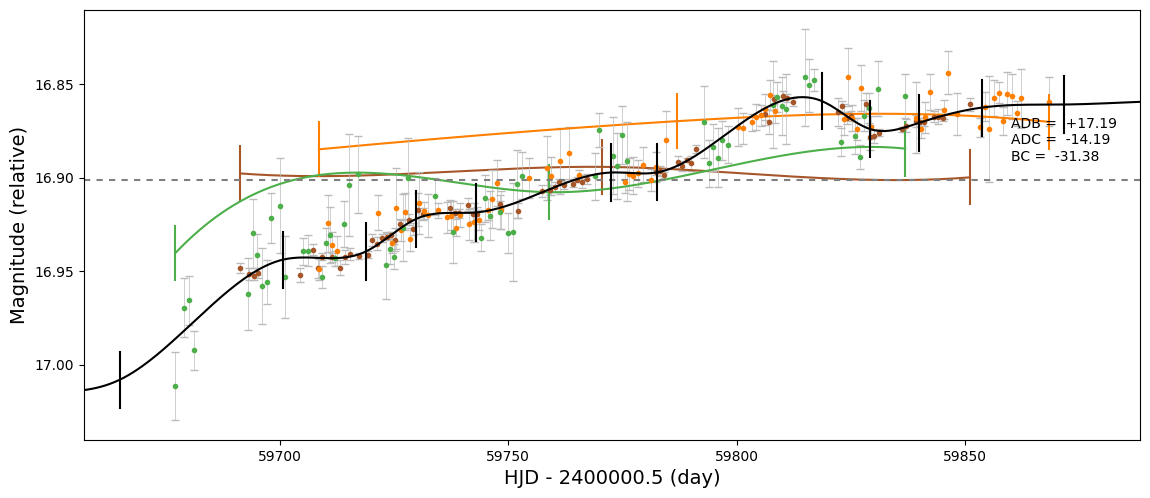

In [37]:
for lc in lcs:
    lc.resetshifts()
lcsuse = lcs
ml1 = 'linear'
ml2 = 'quadratic'
ml3 = 'cubic'
ml3 = 'spline_3_fixed_knot'
ml4 = 'spline_3'
fit(lcsuse, ml3, 25)
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=[ml1, ml2, ml3, ml4], knotstouse=[20, 25])

## DES2038-4008

In [38]:
lensname = 'DES2038-4008'
lcswfi, _ = curve_loader.get_pycs3_curves(lensname, max_scatter=1.5, sigma_outlier=15., cutmask=0, telescope='WFI')
lcswfi = sorted(lcswfi, key=lambda lc: lc.object)

lcseulerend, _ = curve_loader.get_pycs3_curves(lensname, max_scatter=1.5, sigma_outlier=15., cutmask=0, telescope='ECAM')
lcseulerend = sorted(lcseulerend, key=lambda lc: lc.object)



lens='DES2038-4008' and mag_scatter<1.5 and seeing<2.9 and telescope='WFI'
lens='DES2038-4008' and mag_scatter<1.5 and seeing<2.9 and telescope='ECAM'


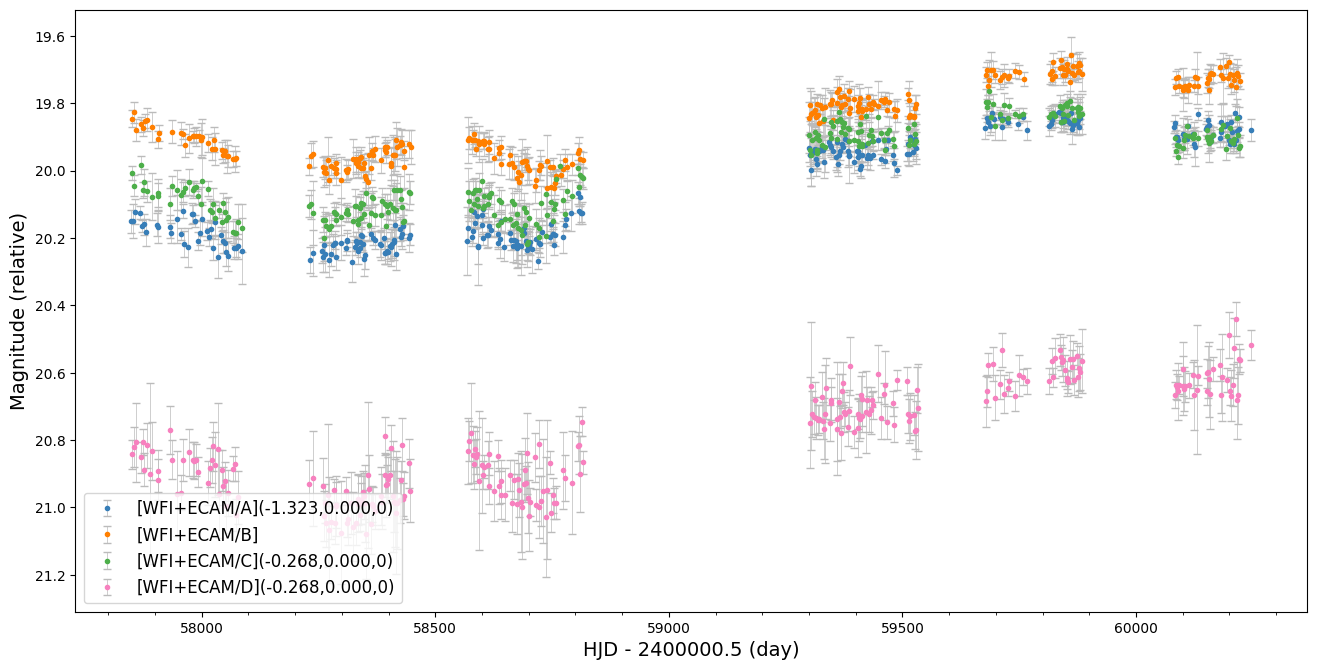

In [39]:
see(lcseulerend, figsize=(14, 7))

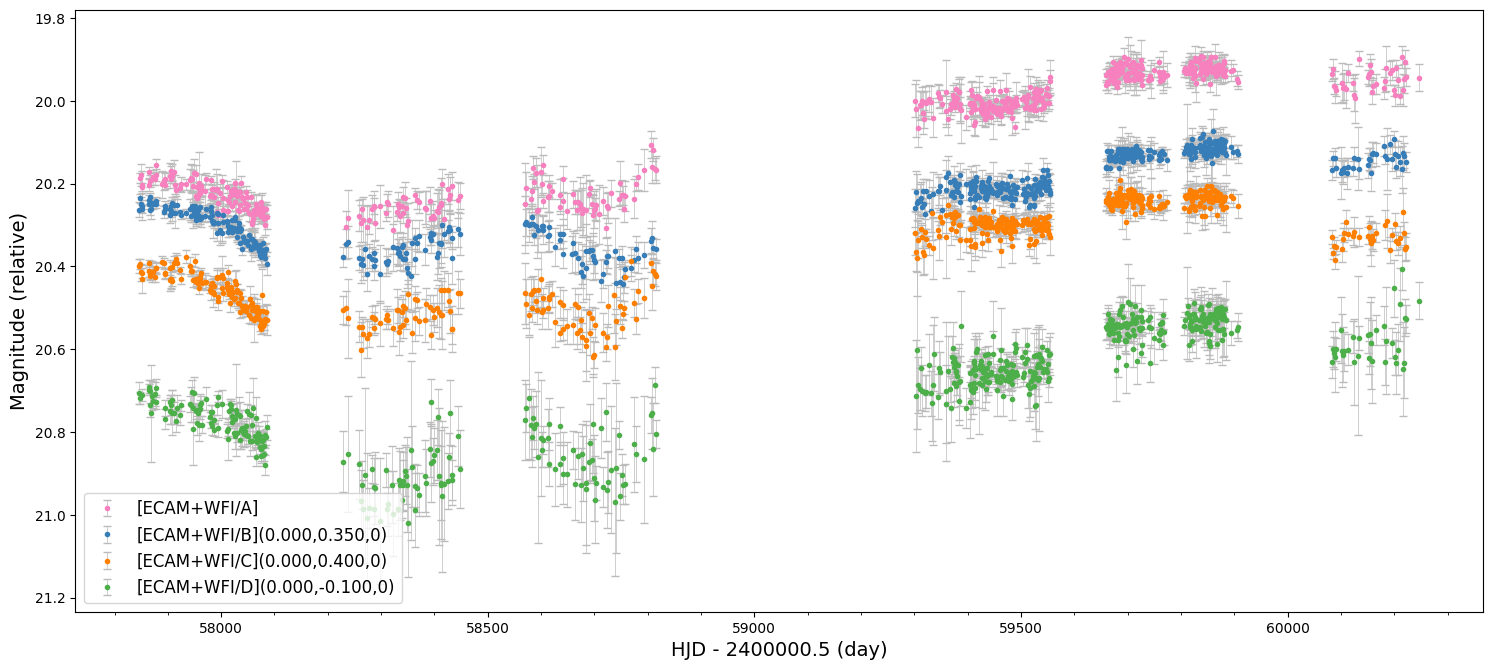

In [40]:
import pycs3.gen.mrg
lce = deepcopy(lcseulerend)
lcw = deepcopy(lcswfi)
for lc in lce:
    lc.mags += 0.04
    if lc.object == 'C':
        lc.mags -= 0.04
    lc.mags[lc.jds>59000] += 0.025
    lc.mask = lc.jds > 58154
    lc.cutmask()
for lc in lcw+lce:
    lc.resetshifts()
    lc.cutmask()
lcs = pycs3.gen.mrg.merge([lcw, lce])
lcs[1].magshift = 0.35
lcs[2].magshift = 0.4
lcs[3].magshift = -0.1
dataset_name = 'ECAM+WFI'
for lc in lcs:
    lc.telescopename = dataset_name
see(lcs, figsize=(16, 7))

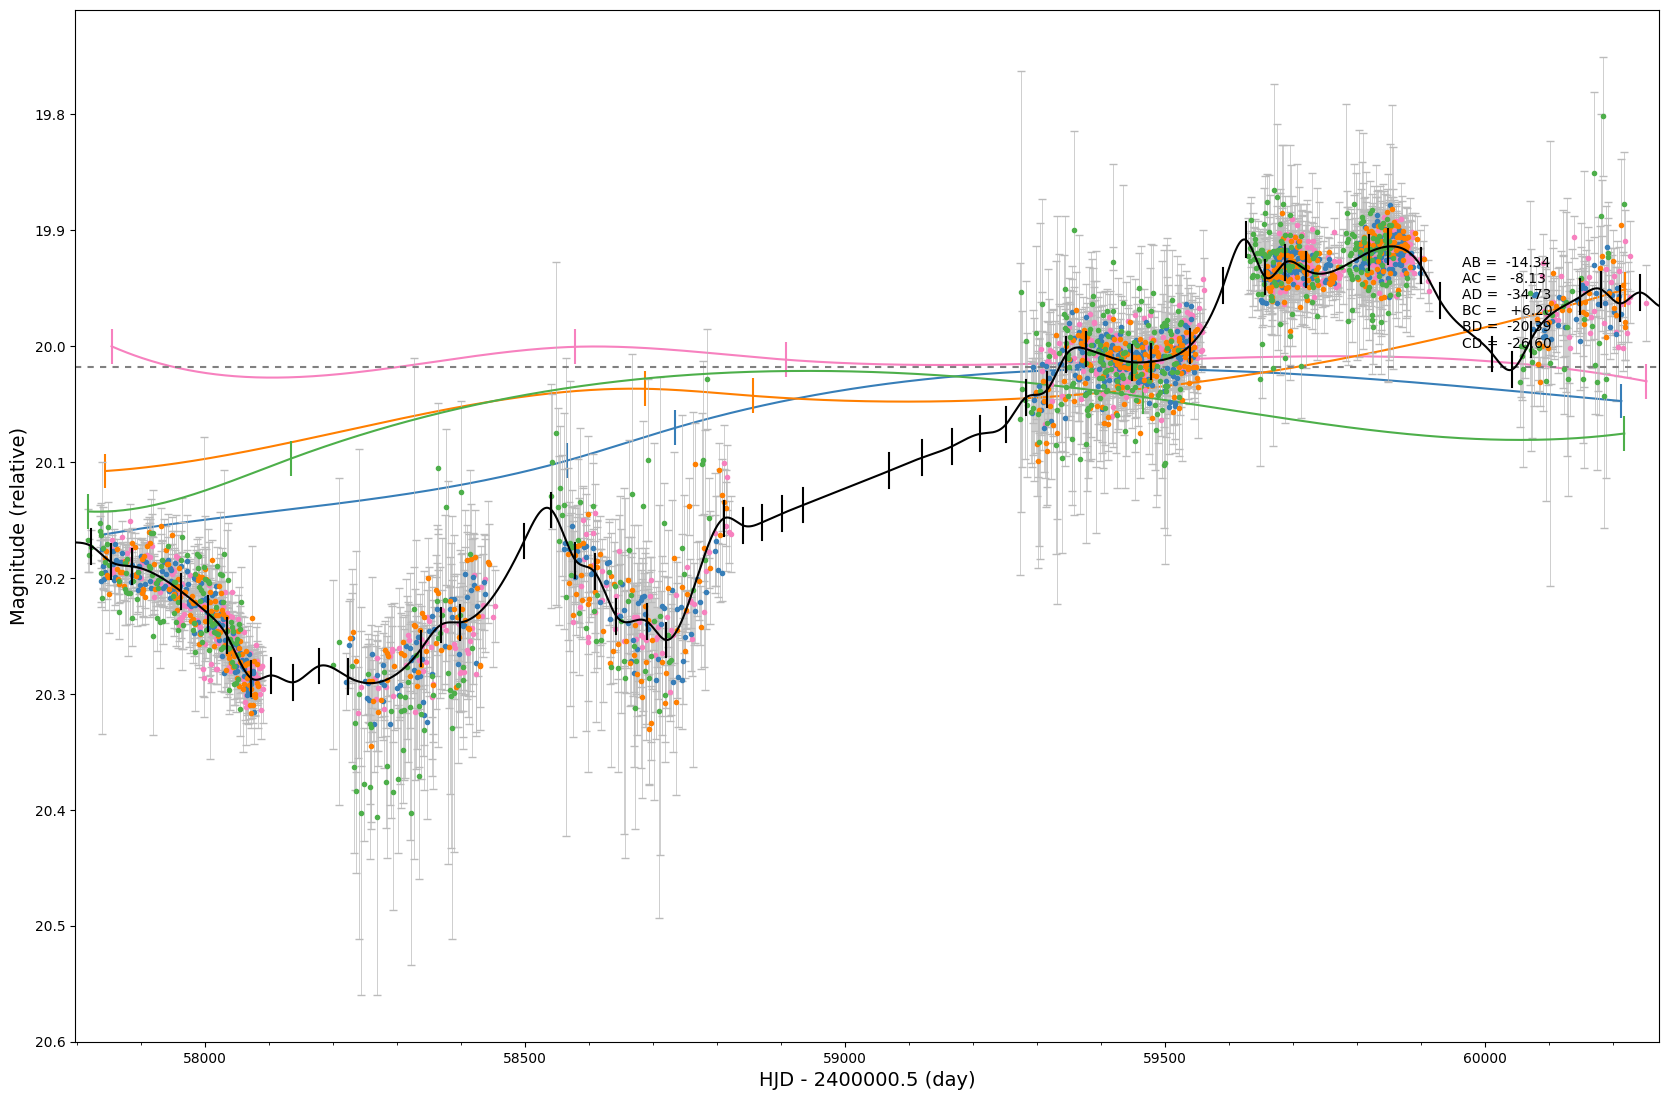

In [41]:
lcsuse = deepcopy(lcs)#lcs[::3] #+ lcs[3:]
lcsuse[0].timeshift = 0
lcsuse[1].timeshift = -9
lcsuse[2].timeshift = -5
lcsuse[3].timeshift = -6
ml1 = 'spline_4'
ml2 = 'spline_5'

fit(lcsuse, ml1, 45, autoseasonsgap=120, rough=1, figsize=(18,12), bokeps=30)
db.save_for_pycs3_run(lensname, dataset_name='ECAMWFI', lcs=lcsuse, mltouse=[ml1, ml2], knotstouse=[40, 45])

## J2100-4452 - WFI

lens='J2100-4452' and mag_scatter<0.2 and seeing<2.9 and telescope='VST'
lens='J2100-4452' and mag_scatter<0.2 and seeing<2.9 and telescope='WFI'


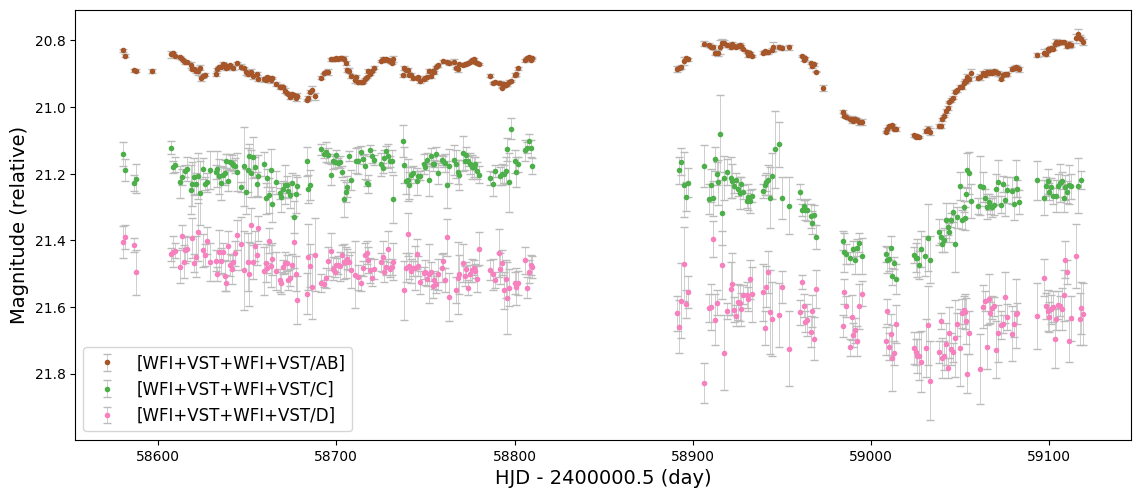

In [42]:
lensname = 'J2100-4452'
lcsvst, dataset_namevst = curve_loader.get_pycs3_curves(lensname, max_scatter=0.2, sigma_outlier=6., cutmask=1, telescope='VST')
lcswfi, dataset_namewfi = curve_loader.get_pycs3_curves(lensname, max_scatter=0.2, sigma_outlier=6., cutmask=1, telescope='WFI')

lcsvst = sorted(lcsvst, key=lambda lc: lc.object)
lcsvst = lcsvst[1:2] + lcsvst[3:]

lcswfi = sorted(lcswfi, key=lambda lc: lc.object)
lcswfi = lcswfi[1:2] + lcswfi[3:]
lcswfi[2].mags -= 0.26

lcs = []
for lcvst, lcwfi in zip(lcsvst, lcswfi):
    lcvst.resetshifts()
    lcwfi.resetshifts()
    lcvst.mags[lcvst.jds>59500] -= 0.1
    lcwfi.mags[lcwfi.jds>59500] -= 0.1
    lcvst.jds[lcvst.jds>59500] -= 800
    lcwfi.jds[lcwfi.jds>59500] -= 800
    lcwfi.mask[lcwfi.jds<59050] = False
    lcwfi.cutmask()
    lcvst = deepcopy(lcvst)
    lcwfi = deepcopy(lcwfi)
    lcvst.merge(lcwfi)
    lcs.append(lcvst)

lcs[0].mags += 2
see(lcs)

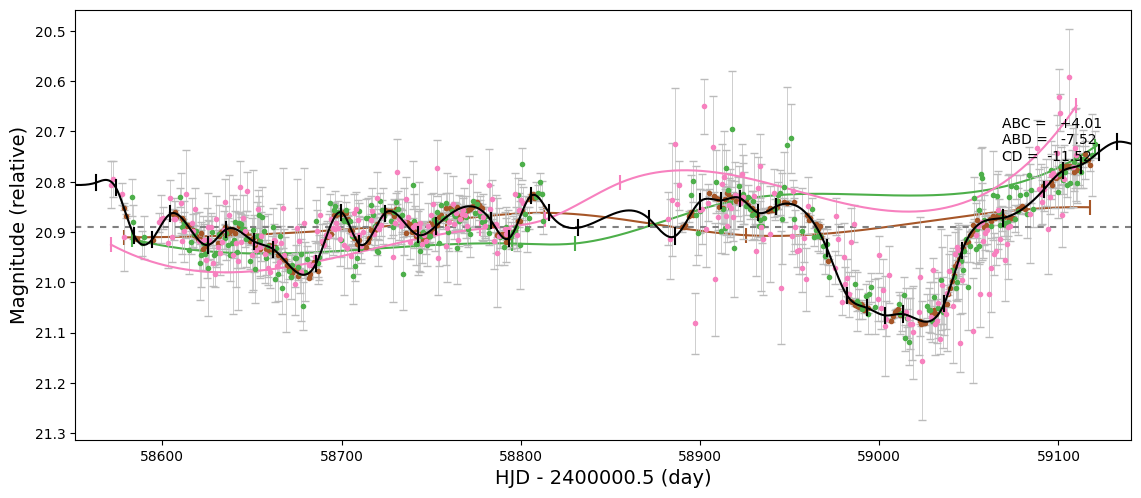

J2100-4452


In [43]:
for lc in lcs:
    lc.resetshifts()
lcsuse = lcs
lcsuse[2].timeshift = -17

ml0 = 'spline_3_fixed_knot'
ml1 = 'spline_3'
ml2 = 'spline_4'
ml3 = 'spline_5'

fit(lcsuse, ml3, 15, autoseasonsgap=1000)
#fit(lcs, 'spline_3', 25)
# comments
print(lensname)
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=[ml1, ml2, ml3], knotstouse=[15, 20])

## J2205-3727 - VST

lens='J2205-3727' and mag_scatter<0.5 and seeing<2.9
VST


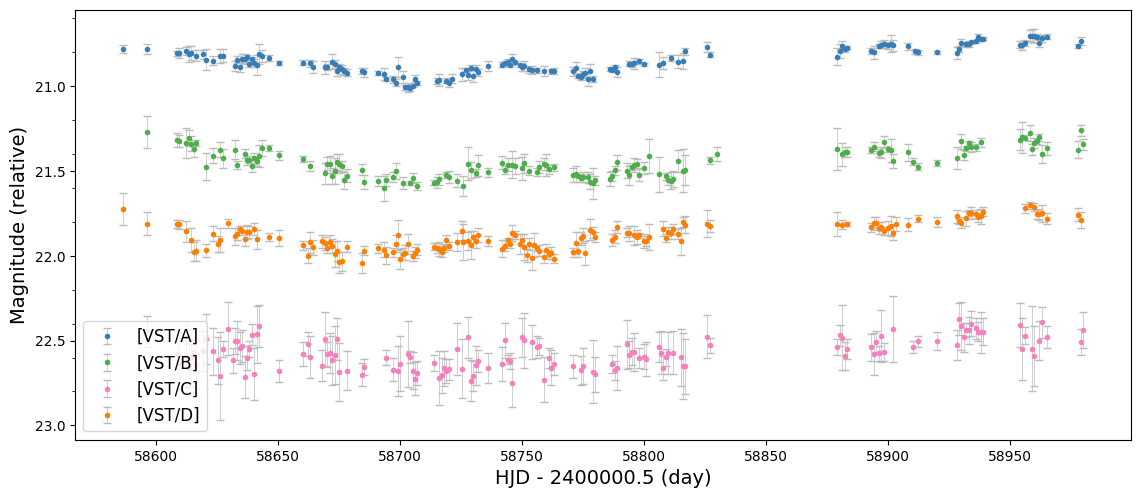

In [44]:
lensname = 'J2205-3727'
lcs, dataset_name = curve_loader.get_pycs3_curves(lensname, max_scatter=0.5, sigma_outlier=1.6, cutmask=1)

print(dataset_name)
lcs = sorted(lcs, key=lambda lc: lc.object)
for lc in lcs:
    lc.timeshift = 0.
    lc.jds[lc.jds > 59500.] -= 830
see(lcs)

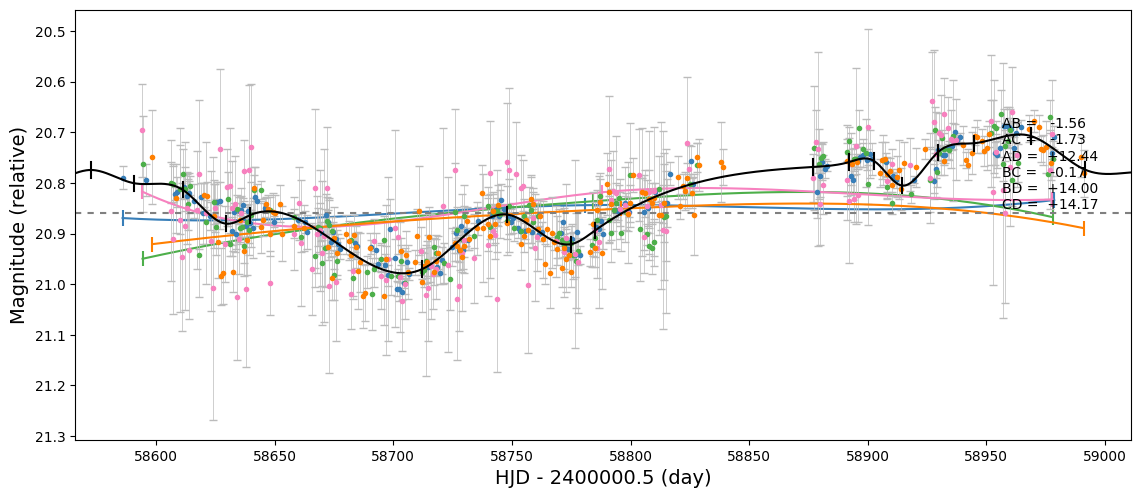

J2205-3727


In [45]:
for lc in lcs:
    lc.resetshifts()
lcs[1].timeshift = -2
lcs[2].timeshift = 0
lcs[3].timeshift = 12.3
lcsuse = lcs
ml0 = 'cubic'
ml1 = 'spline_3_fixed_knot'
ml2 = 'spline_3'

fit(lcsuse, ml1, 30, autoseasonsgap=1000, rough=1)

print(lensname)
db.save_for_pycs3_run(lensname, dataset_name=dataset_name, lcs=lcsuse, mltouse=[ml0, ml1, ml2], knotstouse=[25,30, 35])